Things to do:
- [ ] Create union peaksets
- [ ] Add FLAG peaks to each peakset
- [ ] Quantify reads in peaks
- [ ] Run DESeq2 on those

In [1]:
%%bash
mkdir -p /data/reddylab/Alex/collab/20190701_Matt/data/chip_seq/lib_sizes

### Generate lib_sizes

In [37]:
%%bash
cd /data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/Matt_5756_190620B1-se-with-control/
echo -n > /data/reddylab/Alex/collab/20190701_Matt/data/chip_seq/lib_sizes/Matt_5756_190620B1.all.lib_sizes.tmp.txt
for ii in *.mapped;
do
    iname=$(basename ${ii} | sed 's@.bowtie.log.read_count.mapped@@') && \
    cat ${ii} | cut -f2 >> /data/reddylab/Alex/collab/20190701_Matt/data/chip_seq/lib_sizes/Matt_5756_190620B1.all.lib_sizes.tmp.txt
done
# /data/reddylab/Alex/private-duke-collabs/20181018_Ciofani/data/cut_and_run/counts


In [38]:
%%bash
cd /data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/Matt_5756_190620B1-se-with-control/
paste \
    <(for ii in *.mapped; do basename ${ii} | sed 's@.bowtie.log.read_count.mapped@@'; done) \
    /data/reddylab/Alex/collab/20190701_Matt/data/chip_seq/lib_sizes/Matt_5756_190620B1.all.lib_sizes.tmp.txt \
>  /data/reddylab/Alex/collab/20190701_Matt/data/chip_seq/lib_sizes/Matt_5756_190620B1.all.lib_sizes.txt

Generate Dataframes of counts with cleaned sample headers

In [43]:
%%bash
module load gcc
source /data/reddylab/software/miniconda2/bin/activate alex

for FACTOR in p300.K27ac KRAB.K9me3;
do
    python /data/reddylab/Alex/reddylab_utils/scripts/featurecounts_output_to_df.py \
        -featurecounts \
            /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/counts/mmLiver_${FACTOR}.union_peakset_no_input_plus_flag.featureCounts.txt \
        --drop-suffixes \
            /data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/Matt_5756_190620B1-se-with-control/ \
            .masked.dedup.sorted.bam \
        -outfiles \
            /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/counts/mmLiver_${FACTOR}.union_peakset_no_input_plus_flag.featureCounts.df.txt
done
echo "Done"

Done


In [19]:
%%bash
module load gcc
source /data/reddylab/software/miniconda2/bin/activate alex
# p300.K27ac KRAB.K9me3
for FACTOR in p300.flag KRAB.flag;
do
    python /data/reddylab/Alex/reddylab_utils/scripts/featurecounts_output_to_df.py \
        -featurecounts \
            /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/counts/mmLiver_${FACTOR}.union_peakset_no_input.featureCounts.txt \
        --drop-suffixes \
            /data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/Matt_5756_190620B1-se-with-control/ \
            .masked.dedup.sorted.bam \
        -outfiles \
            /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/counts/mmLiver_${FACTOR}.union_peakset_no_input.featureCounts.df.txt
done
echo "Done"

Done


In [44]:
%%bash
mkdir -p /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/differential_testing/deseq2
source /data/reddylab/software/miniconda2/bin/activate alex_dev
sbatch -pnew,all \
    -x $(cat /home/aeb84/.slurm_exclude_list.txt) \
    --array=0-5 \
    --mem 16G \
    -o /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/logs/chipseq_deseq2.mmLiver.%a.out \
    <<'EOF'
#!/bin/bash
COMPARISONS=( \
    mmLiver_p300.K27ac.targeted-mmLiver_p300.K27ac.PBS \
    mmLiver_p300.K27ac.targeted-mmLiver_p300.K27ac.scram \
    mmLiver_p300.K27ac.scram-mmLiver_p300.K27ac.PBS \
    mmLiver_KRAB.K9me3.targeted-mmLiver_KRAB.K9me3.PBS \
    mmLiver_KRAB.K9me3.targeted-mmLiver_KRAB.K9me3.scram \
    mmLiver_KRAB.K9me3.scram-mmLiver_KRAB.K9me3.PBS \
)

COMPARISON=${COMPARISONS[${SLURM_ARRAY_TASK_ID}]}
TREAT=$(echo $COMPARISON | cut -d"-" -f1)
CONTROL=$(echo $COMPARISON | cut -d"-" -f2)
FACTOR=$(echo ${CONTROL} | cut -d. -f1-2 | cut -d_ -f2-)
#     --lib-sizes /data/reddylab/Alex/collab/20190701_Matt/data/chip_seq/lib_sizes/Matt_5756_190620B1.all.lib_sizes.txt \
Rscript /data/reddylab/Alex/reddylab_utils/scripts/de.deseq2.R \
    --lfcShrink ashr \
    --no-model-reps \
    --treatments \
        $( head -n1 /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/counts/mmLiver_${FACTOR}.union_peakset_no_input_plus_flag.featureCounts.df.txt | tr '\t' '\n' | /bin/grep ${TREAT}) \
    --controls \
        $( head -n1 /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/counts/mmLiver_${FACTOR}.union_peakset_no_input_plus_flag.featureCounts.df.txt | tr '\t' '\n' | /bin/grep ${CONTROL}) \
    --outdir /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/differential_testing/deseq2 \
    --counts /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/counts/mmLiver_${FACTOR}.union_peakset_no_input_plus_flag.featureCounts.df.txt
EOF


Submitted batch job 10183173


Add closest gene

In [5]:
%%bash
cd /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/differential_testing/deseq2

SAMPLES=($(/bin/ls -1 *.{PBS,scram,PBS.unshrunk,scram.unshrunk}.txt))
sbatch -pnew,all \
    --array=0-$((${#SAMPLES[@]}-1)) \
    --cpus-per-task 1 \
    --mem 4G \
    -o /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/logs/chipseq_deseq2.mmLiver.add_closest_gene.%a.out \
    <<'EOF'
#!/bin/bash

SAMPLES=($(/bin/ls -1 *.{PBS,scram,PBS.unshrunk,scram.unshrunk}.txt))
SAMPLE=${SAMPLES[${SLURM_ARRAY_TASK_ID}]}

tail -n+2 ${SAMPLE} \
| awk -F_ -vOFS="\t" '{print $1, $2, $3}' \
| cut -f1,2,3 \
| awk -vOFS="\t" '{print $1, $2, $3, $1"_"$2"_"$3}' \
| sort -k1,1 -k2,2n \
| bedtools closest \
    -wa \
    -nonamecheck \
    -D a \
    -a - \
    -b /data/reddylab/Reference_Data/Gencode/vM19/gencode.vM19.basic.annotation.bed \
| awk -vOFS="\t" \
    '{if(last==$4){genes=$11","genes;}else{if(genes){print peak, genes, distance}peak=$4; genes=$11; distance=$13; last=peak}}END{if(last==$4){genes=$11","genes;print peak, genes, distance}}' \
> ${SAMPLE/.txt/.closest_gene.txt}

EOF

Submitted batch job 10188743


In [7]:
%%bash
cd /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/differential_testing/deseq2

SAMPLES=($(/bin/ls -1 *.{PBS,scram,PBS.unshrunk,scram.unshrunk}.txt))
sbatch -pnew,all \
    --array=0-$((${#SAMPLES[@]}-1)) \
    --cpus-per-task 1 \
    --mem 4G \
    -o /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/logs/chipseq_deseq2.mmLiver.add_closest_tss.%a.out \
    <<'EOF'
#!/bin/bash

SAMPLES=($(/bin/ls -1 *.{PBS,scram,PBS.unshrunk,scram.unshrunk}.txt))
SAMPLE=${SAMPLES[${SLURM_ARRAY_TASK_ID}]}

tail -n+2 ${SAMPLE} \
| awk -F_ -vOFS="\t" '{print $1, $2, $3}' \
| cut -f1,2,3 \
| awk -vOFS="\t" '{print $1, $2, $3, $1"_"$2"_"$3}' \
| sort -k1,1 -k2,2n \
| bedtools closest \
    -wa \
    -nonamecheck \
    -D a \
    -a - \
    -b <(sort -k1,1 -k2,2n /data/reddylab/Reference_Data/Gencode/vM19/gencode.vM19.basic.annotation.TSS.bed) \
| awk -vOFS="\t" \
    '{if(last==$4){genes=$11","genes;}else{if(genes){print peak, genes, distance}peak=$4; genes=$11; distance=$13; last=peak}}END{if(last==$4){genes=$11","genes;print peak, genes, distance}}' \
> ${SAMPLE/.txt/.closest_tss.txt}

EOF

Submitted batch job 23859654


Add closest gene info to DESeq2 results -- UPDATE: I'm changing to use TSS instead of gene body

In [8]:
import pandas as pd
samples = [
    "mmLiver_p300.K27ac.targeted_vs_mmLiver_p300.K27ac.PBS",
    "mmLiver_p300.K27ac.targeted_vs_mmLiver_p300.K27ac.scram",
    "mmLiver_p300.K27ac.scram_vs_mmLiver_p300.K27ac.PBS",
    "mmLiver_KRAB.K9me3.targeted_vs_mmLiver_KRAB.K9me3.PBS",
    "mmLiver_KRAB.K9me3.targeted_vs_mmLiver_KRAB.K9me3.scram",
    "mmLiver_KRAB.K9me3.scram_vs_mmLiver_KRAB.K9me3.PBS",
]
data_dir = '/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/differential_testing/deseq2'
for sample in samples:
    for shrinkage in ['', '.unshrunk']:
        df = pd.read_csv("%s/%s%s.txt" % (data_dir, sample, shrinkage), sep='\t')
        df_closest= pd.read_csv("%s/%s.closest_tss.txt" % (data_dir, sample), index_col=0, sep='\t',
                                names=['peak', 'genes', 'distance'])
        df.join(df_closest, how='outer')\
            .sort_values(by=['padj'])\
            .to_csv("%s/%s%s.with_closest_gene.txt" % (data_dir, sample, shrinkage), sep='\t')

Create annotated MA plots 

In [3]:
%matplotlib inline

====== mmLiver_p300.K27ac.targeted_vs_mmLiver_p300.K27ac.PBS ======
====== mmLiver_p300.K27ac.targeted_vs_mmLiver_p300.K27ac.PBS ======
====== mmLiver_p300.K27ac.targeted_vs_mmLiver_p300.K27ac.scram ======
====== mmLiver_p300.K27ac.targeted_vs_mmLiver_p300.K27ac.scram ======
====== mmLiver_KRAB.K9me3.targeted_vs_mmLiver_KRAB.K9me3.PBS ======
====== mmLiver_KRAB.K9me3.targeted_vs_mmLiver_KRAB.K9me3.PBS ======
====== mmLiver_KRAB.K9me3.targeted_vs_mmLiver_KRAB.K9me3.scram ======
====== mmLiver_KRAB.K9me3.targeted_vs_mmLiver_KRAB.K9me3.scram ======


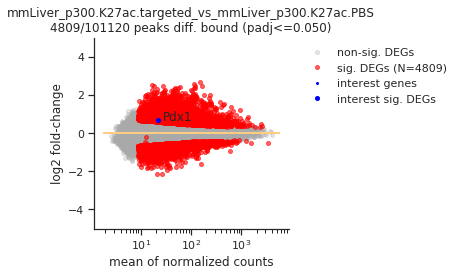

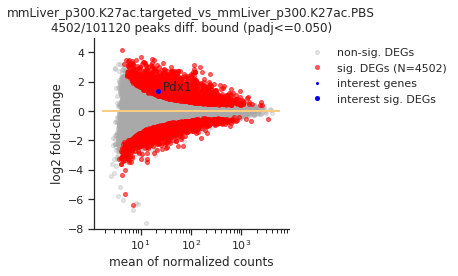

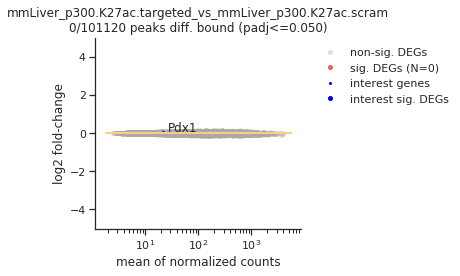

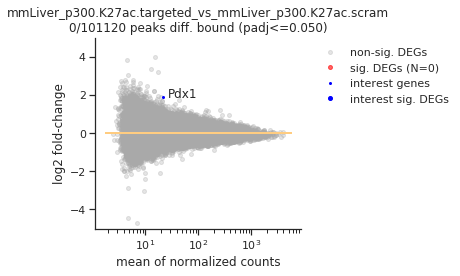

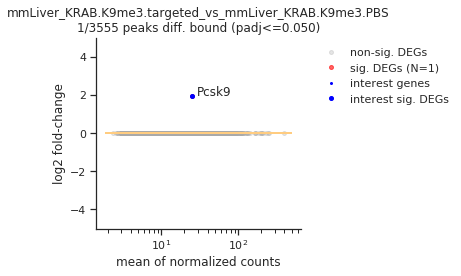

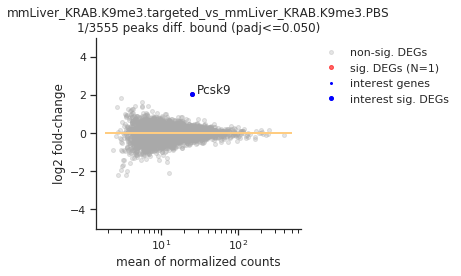

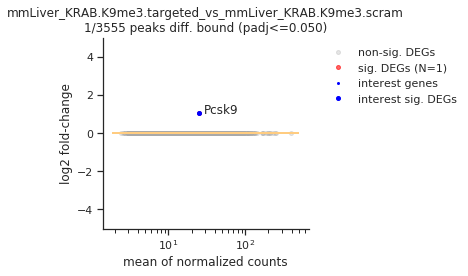

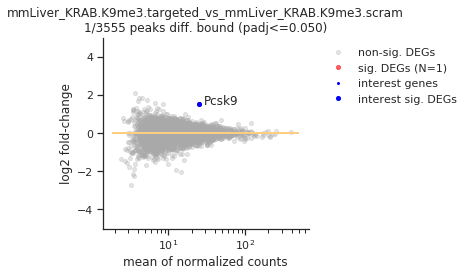

In [52]:
from IPython.display import display
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context("notebook")
plt.rcParams['pdf.fonttype'] = 42
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

# Config
pval_thres = 0.1

for pval_thres in [0.05]: #0.1, 0.05
    top_to_report = 4000
    special_genes = ['Pdx1', 'Pcsk9']
    comparisons = [
        "mmLiver_p300.K27ac.targeted_vs_mmLiver_p300.K27ac.PBS",
        "mmLiver_p300.K27ac.targeted_vs_mmLiver_p300.K27ac.scram",
#         "mmLiver_p300.K27ac.scram_vs_mmLiver_p300.K27ac.PBS",
        "mmLiver_KRAB.K9me3.targeted_vs_mmLiver_KRAB.K9me3.PBS",
        "mmLiver_KRAB.K9me3.targeted_vs_mmLiver_KRAB.K9me3.scram",
#         "mmLiver_KRAB.K9me3.scram_vs_mmLiver_KRAB.K9me3.PBS",
    ]

    data_dir = '/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/differential_testing/deseq2'

    for comparison in comparisons:
        if 'K27ac' in comparison:
            special_genes = ['Pdx1']
        else:
            special_genes = ['Pcsk9']

        for shrinkage in ['', '.unshrunk']: #'.unshrunk', 
            df = pd.read_csv("%s/%s%s.with_closest_gene.txt" % (data_dir, comparison, shrinkage),
                            sep="\t", index_col=0)
            df.loc[df.padj.isna(), 'padj'] = 1
        #     df.loc[:, "genes"] = df.index
#             fig = plt.figure(figsize=(5, 3))#figsize=(12, 10))
#             fig = plt.figure(figsize=(8, 6))
            fig = plt.figure(figsize=(6, 4))
            ax = plt.subplot(1, 1, 1)
            df_non_sig = df[~(df.padj<pval_thres) & (~df.genes.isin(special_genes))]
            ax.set_xscale('log')
            ax.plot(df_non_sig['baseMean'].values, 
                    df_non_sig['log2FoldChange'].values, 
                    'o', color='darkgrey', label='non-sig. DEGs', alpha=.3, markersize=4, rasterized=True)

            ylims = [np.min([np.ceil(df['log2FoldChange'].min()-1), -5]), 
                     np.max([np.floor(df['log2FoldChange'].max()+1), 5])]
            df_sig = df[df.padj<=pval_thres]
            ax.plot(df_sig['baseMean'].values, df_sig['log2FoldChange'].values, 'ro', alpha=0.6, markersize=4,
                    label='sig. DEGs (N=%d)' % df_sig.shape[0])

            # Annotate the top top_to_report
            df_annotate = df_sig.sort_values(by='padj', ascending=True).head(top_to_report)

            # Annotate in particular IL1RN, HBG and EP300
            df_annotate_selected = df[df.genes.isin(special_genes)]
            ax.plot(df_annotate_selected['baseMean'].values,
                    df_annotate_selected['log2FoldChange'].values, markersize=4,color='blue', 
                    marker='.', linestyle = 'None', alpha=1, label='interest genes')
            for x, y, t in zip(df_annotate_selected['baseMean'].values,
                               df_annotate_selected['log2FoldChange'].values, 
                               df_annotate_selected['genes'].values) :
                ax.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left',
                        textcoords='offset points')
            df_annotate_selected = df_sig[df_sig.genes.isin(special_genes)]
            ax.plot(df_annotate_selected['baseMean'].values,
                    df_annotate_selected['log2FoldChange'].values, markersize=4,color='blue', 
                    marker='o', linestyle = 'None', alpha=1, label='interest sig. DEGs')

            plt.ylim(ylims)
            plt.xlabel("mean of normalized counts")
            plt.ylabel("log2 fold-change")
            plt.title("%s\n%d/%d peaks diff. bound (padj<=%.3f)" % (comparison, 
                                                                     np.count_nonzero(df.padj<=pval_thres),
                                                                     df.shape[0], 
                                                                        pval_thres))
#             plt.hlines(0, 0, df['baseMean'].max(), color='#ffcc80', linewidth =2)
            plt.hlines(0, ax.xaxis._axes.get_xlim()[0], ax.xaxis._axes.get_xlim()[1], 
                       color='#ffcc80', linewidth =2,zorder=100 )

            plt.xlim(ax.xaxis._axes.get_xlim())
            # plot legend
            plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", frameon=False)

            # Remove spines and tight the layout
            simpleaxis(ax)
            plt.tight_layout()

            # Save annotated MA plot
            plt.savefig("/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/differential_testing/deseq2/degs.%s%s.with_genes.annotated_plot_MA.small.pdf" % (comparison, shrinkage))
#             plt.savefig("/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/differential_testing/deseq2/degs.%s%s.with_genes.annotated_plot_MA.fdr_%.2f.pdf" % (comparison, shrinkage, pval_thres))

        #     # Save annotated genes without pseudogenes
        #     df_annotate.to_csv("/data/reddylab/Alex/collab/20180214_JoshBlack/results/rna_seq/degs%s.with_genes.sig_DE_no_pseudogenes.txt" % comparison,
        #                       sep='\t',
        #                       index=False)

            # print table of values 
            print "======", comparison, "======"
#             display(df_annotate)

   


Same, but for the FLAGs

In [22]:
%%bash
mkdir -p /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/differential_testing/deseq2/flags
source /data/reddylab/software/miniconda2/bin/activate alex_dev
sbatch -pnew,all \
    -x $(cat /home/aeb84/.slurm_exclude_list.txt) \
    --array=0-5 \
    --mem 16G \
    -o /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/logs/chipseq_deseq2.mmLiver.flags.%a.out \
    <<'EOF'
#!/bin/bash
COMPARISONS=( \
    mmLiver_p300.flag.targeted-mmLiver_p300.flag.PBS \
    mmLiver_p300.flag.targeted-mmLiver_p300.flag.scram \
    mmLiver_p300.flag.scram-mmLiver_p300.flag.PBS \
    mmLiver_KRAB.flag.targeted-mmLiver_KRAB.flag.PBS \
    mmLiver_KRAB.flag.targeted-mmLiver_KRAB.flag.scram \
    mmLiver_KRAB.flag.scram-mmLiver_KRAB.flag.PBS \
)

COMPARISON=${COMPARISONS[${SLURM_ARRAY_TASK_ID}]}
TREAT=$(echo $COMPARISON | cut -d"-" -f1)
CONTROL=$(echo $COMPARISON | cut -d"-" -f2)
FACTOR=$(echo ${CONTROL} | cut -d. -f1-2 | cut -d_ -f2-)
#     --lib-sizes /data/reddylab/Alex/collab/20190701_Matt/data/chip_seq/lib_sizes/Matt_5756_190620B1.all.lib_sizes.txt \
Rscript /data/reddylab/Alex/reddylab_utils/scripts/de.deseq2.R \
    --lfcShrink ashr \
    --no-model-reps \
    --treatments \
        $( head -n1 /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/counts/mmLiver_${FACTOR}.union_peakset_no_input.featureCounts.df.txt | tr '\t' '\n' | /bin/grep ${TREAT}) \
    --controls \
        $( head -n1 /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/counts/mmLiver_${FACTOR}.union_peakset_no_input.featureCounts.df.txt | tr '\t' '\n' | /bin/grep ${CONTROL}) \
    --outdir /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/differential_testing/deseq2/flags \
    --counts /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/counts/mmLiver_${FACTOR}.union_peakset_no_input.featureCounts.df.txt
EOF


Submitted batch job 10220689


Add closest gene

In [23]:
%%bash
cd /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/differential_testing/deseq2/flags

SAMPLES=($(/bin/ls -1 *.{PBS,scram,PBS.unshrunk,scram.unshrunk}.txt))
sbatch -pnew,all \
    --array=0-$((${#SAMPLES[@]}-1)) \
    --cpus-per-task 1 \
    --mem 4G \
    -o /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/logs/chipseq_deseq2.mmLiver.flags.add_closest_gene.%a.out \
    <<'EOF'
#!/bin/bash

SAMPLES=($(/bin/ls -1 *.{PBS,scram,PBS.unshrunk,scram.unshrunk}.txt))
SAMPLE=${SAMPLES[${SLURM_ARRAY_TASK_ID}]}

tail -n+2 ${SAMPLE} \
| awk -F_ -vOFS="\t" '{print $1, $2, $3}' \
| cut -f1,2,3 \
| awk -vOFS="\t" '{print $1, $2, $3, $1"_"$2"_"$3}' \
| sort -k1,1 -k2,2n \
| bedtools closest \
    -wa \
    -nonamecheck \
    -D a \
    -a - \
    -b /data/reddylab/Reference_Data/Gencode/vM19/gencode.vM19.basic.annotation.bed \
| awk -vOFS="\t" \
    '{if(last==$4){genes=$11","genes;}else{if(genes){print peak, genes, distance}peak=$4; genes=$11; distance=$13; last=peak}}END{if(last==$4){genes=$11","genes;print peak, genes, distance}}' \
> ${SAMPLE/.txt/.closest_gene.txt}

EOF

Submitted batch job 10220694


In [1]:
%%bash
cd /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/differential_testing/deseq2/flags

SAMPLES=($(/bin/ls -1 *.{PBS,scram,PBS.unshrunk,scram.unshrunk}.txt))
sbatch -pnew,all \
    --array=0-$((${#SAMPLES[@]}-1)) \
    --cpus-per-task 1 \
    --mem 4G \
    -o /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/logs/chipseq_deseq2.mmLiver.flags.add_closest_tss.%a.out \
    <<'EOF'
#!/bin/bash

SAMPLES=($(/bin/ls -1 *.{PBS,scram,PBS.unshrunk,scram.unshrunk}.txt))
SAMPLE=${SAMPLES[${SLURM_ARRAY_TASK_ID}]}

tail -n+2 ${SAMPLE} \
| awk -F_ -vOFS="\t" '{print $1, $2, $3}' \
| cut -f1,2,3 \
| awk -vOFS="\t" '{print $1, $2, $3, $1"_"$2"_"$3}' \
| sort -k1,1 -k2,2n \
| bedtools closest \
    -wa \
    -nonamecheck \
    -D a \
    -a - \
    -b <(sort -k1,1 -k2,2n /data/reddylab/Reference_Data/Gencode/vM19/gencode.vM19.basic.annotation.TSS.bed) \
| awk -vOFS="\t" \
    '{if(last==$4){genes=$11","genes;}else{if(genes){print peak, genes, distance}peak=$4; genes=$11; distance=$13; last=peak}}END{if(last==$4){genes=$11","genes;print peak, genes, distance}}' \
> ${SAMPLE/.txt/.closest_tss.txt}

EOF

Submitted batch job 23859887


Add closest gene info to DESeq2 results -- UPDATE: change gene bodies to TSSs

In [2]:
import pandas as pd
samples = [
    "mmLiver_p300.flag.targeted_vs_mmLiver_p300.flag.PBS",
    "mmLiver_p300.flag.targeted_vs_mmLiver_p300.flag.scram",
    "mmLiver_p300.flag.scram_vs_mmLiver_p300.flag.PBS",
    "mmLiver_KRAB.flag.targeted_vs_mmLiver_KRAB.flag.PBS",
    "mmLiver_KRAB.flag.targeted_vs_mmLiver_KRAB.flag.scram",
    "mmLiver_KRAB.flag.scram_vs_mmLiver_KRAB.flag.PBS",
]
data_dir = '/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/differential_testing/deseq2/flags/'
for sample in samples:
    for shrinkage in ['', '.unshrunk']:
        df = pd.read_csv("%s/%s%s.txt" % (data_dir, sample, shrinkage), sep='\t')
        df_closest= pd.read_csv("%s/%s.closest_tss.txt" % (data_dir, sample), index_col=0, sep='\t',
                                names=['peak', 'genes', 'distance'])
        df.join(df_closest, how='outer')\
            .sort_values(by=['padj'])\
            .to_csv("%s/%s%s.with_closest_gene.txt" % (data_dir, sample, shrinkage), sep='\t')

In [1]:
%matplotlib inline

====== mmLiver_p300.flag.targeted_vs_mmLiver_p300.flag.PBS ======
====== mmLiver_p300.flag.targeted_vs_mmLiver_p300.flag.PBS ======
====== mmLiver_p300.flag.targeted_vs_mmLiver_p300.flag.scram ======
====== mmLiver_p300.flag.targeted_vs_mmLiver_p300.flag.scram ======
====== mmLiver_p300.flag.scram_vs_mmLiver_p300.flag.PBS ======
====== mmLiver_p300.flag.scram_vs_mmLiver_p300.flag.PBS ======
====== mmLiver_KRAB.flag.targeted_vs_mmLiver_KRAB.flag.PBS ======
====== mmLiver_KRAB.flag.targeted_vs_mmLiver_KRAB.flag.PBS ======
====== mmLiver_KRAB.flag.targeted_vs_mmLiver_KRAB.flag.scram ======
====== mmLiver_KRAB.flag.targeted_vs_mmLiver_KRAB.flag.scram ======
====== mmLiver_KRAB.flag.scram_vs_mmLiver_KRAB.flag.PBS ======
====== mmLiver_KRAB.flag.scram_vs_mmLiver_KRAB.flag.PBS ======
====== mmLiver_p300.flag.targeted_vs_mmLiver_p300.flag.PBS ======
====== mmLiver_p300.flag.targeted_vs_mmLiver_p300.flag.PBS ======
====== mmLiver_p300.flag.targeted_vs_mmLiver_p300.flag.scram ======
====== mmLiv

/data/reddylab/software/miniconda2/envs/alex_dev/lib/python2.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


====== mmLiver_KRAB.flag.targeted_vs_mmLiver_KRAB.flag.scram ======
====== mmLiver_KRAB.flag.targeted_vs_mmLiver_KRAB.flag.scram ======
====== mmLiver_KRAB.flag.scram_vs_mmLiver_KRAB.flag.PBS ======
====== mmLiver_KRAB.flag.scram_vs_mmLiver_KRAB.flag.PBS ======
====== mmLiver_p300.flag.targeted_vs_mmLiver_p300.flag.PBS ======
====== mmLiver_p300.flag.targeted_vs_mmLiver_p300.flag.PBS ======
====== mmLiver_p300.flag.targeted_vs_mmLiver_p300.flag.scram ======
====== mmLiver_p300.flag.targeted_vs_mmLiver_p300.flag.scram ======
====== mmLiver_p300.flag.scram_vs_mmLiver_p300.flag.PBS ======
====== mmLiver_p300.flag.scram_vs_mmLiver_p300.flag.PBS ======
====== mmLiver_KRAB.flag.targeted_vs_mmLiver_KRAB.flag.PBS ======
====== mmLiver_KRAB.flag.targeted_vs_mmLiver_KRAB.flag.PBS ======
====== mmLiver_KRAB.flag.targeted_vs_mmLiver_KRAB.flag.scram ======
====== mmLiver_KRAB.flag.targeted_vs_mmLiver_KRAB.flag.scram ======
====== mmLiver_KRAB.flag.scram_vs_mmLiver_KRAB.flag.PBS ======
====== mmLive

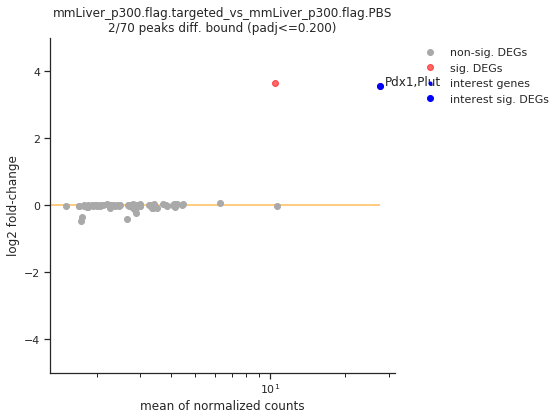

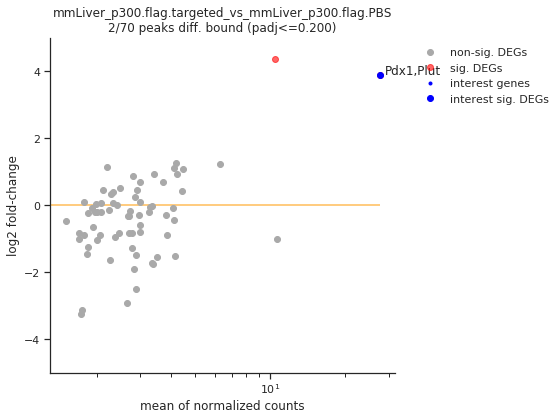

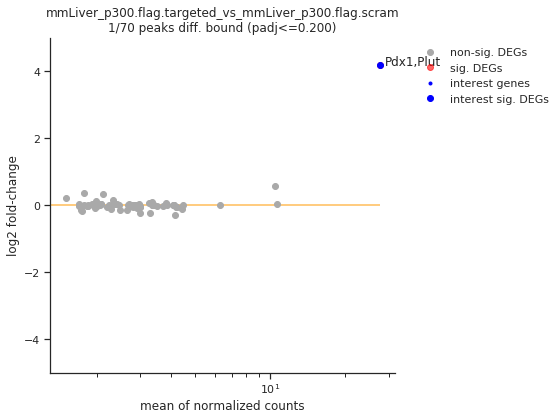

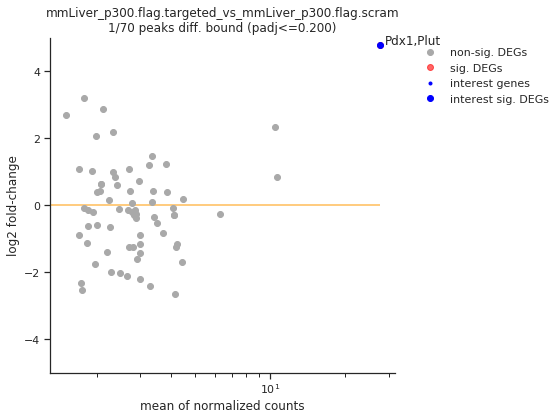

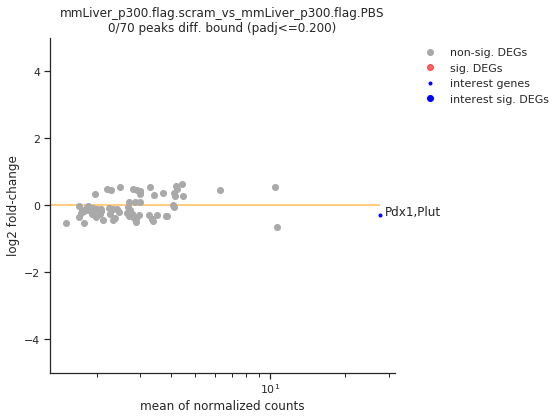

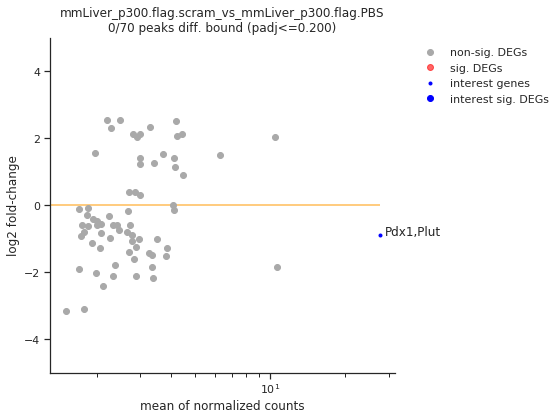

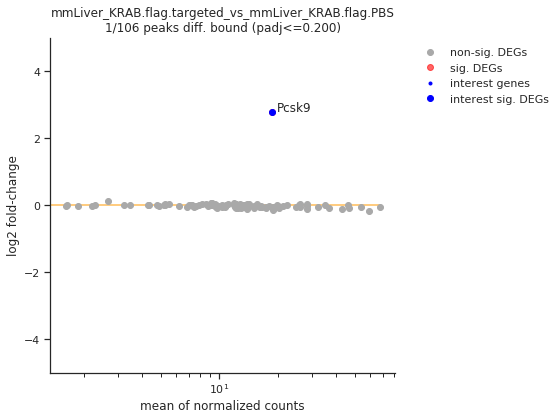

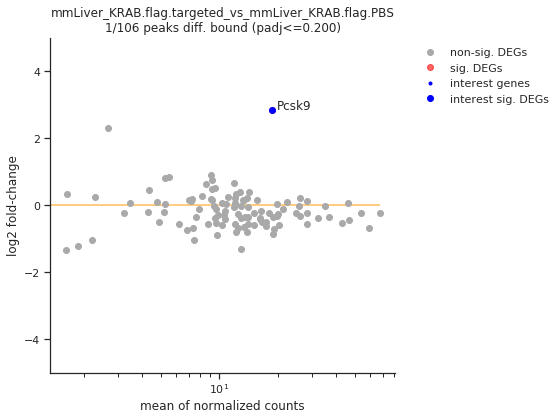

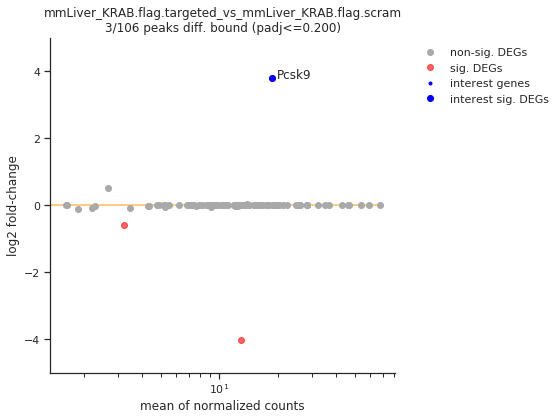

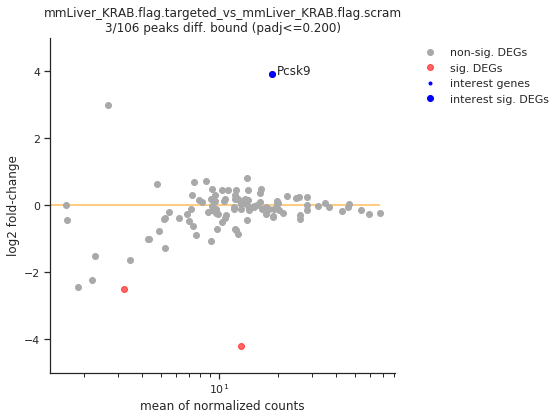

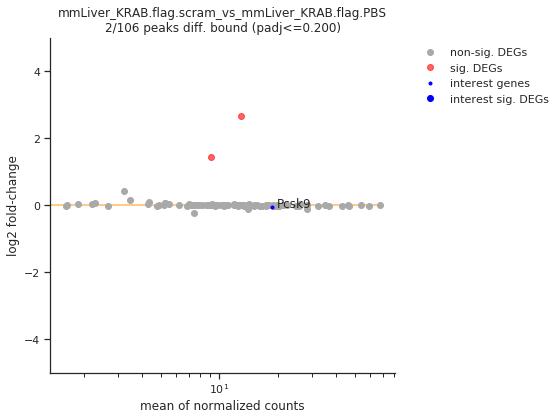

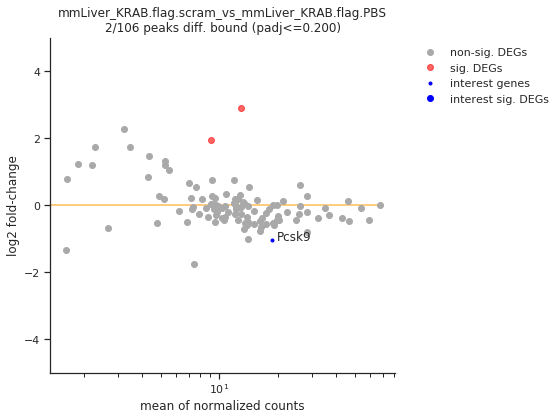

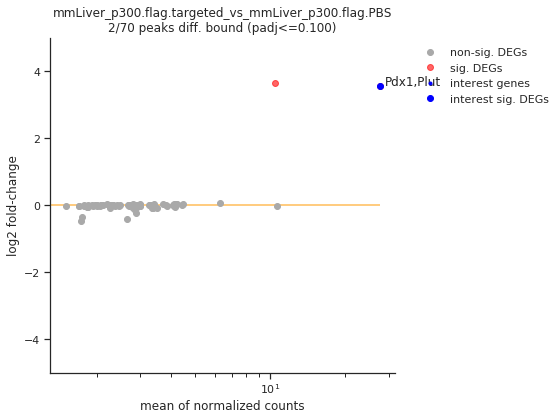

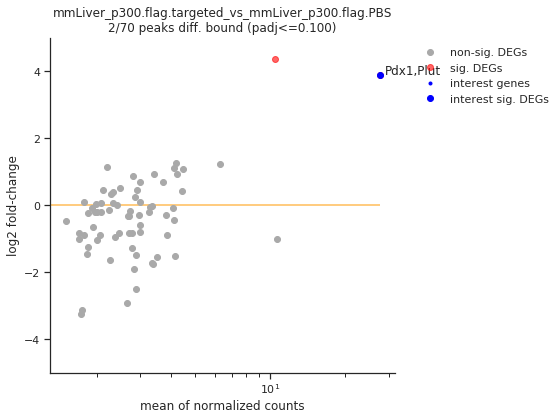

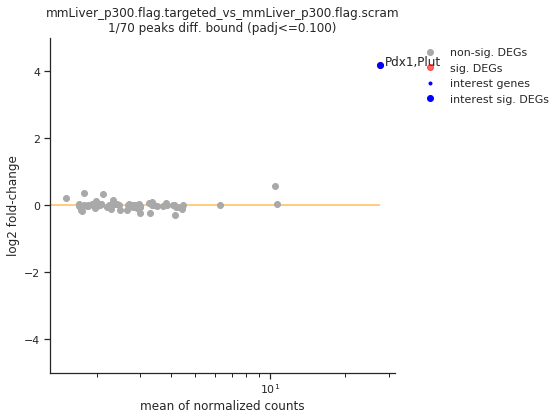

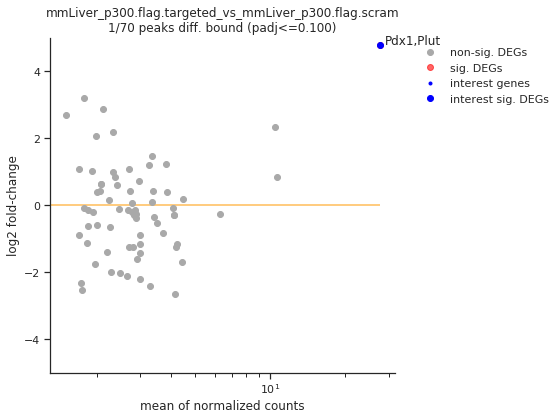

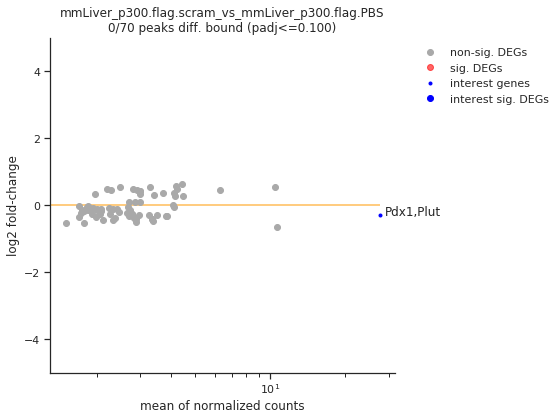

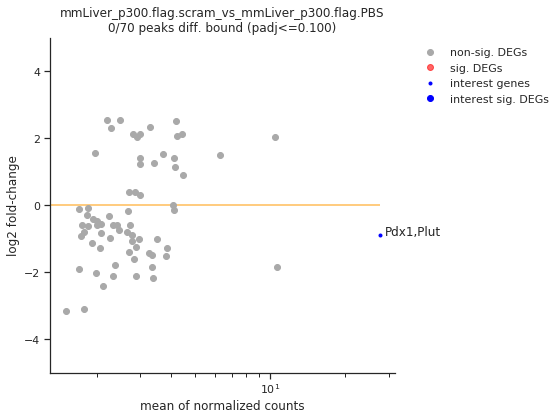

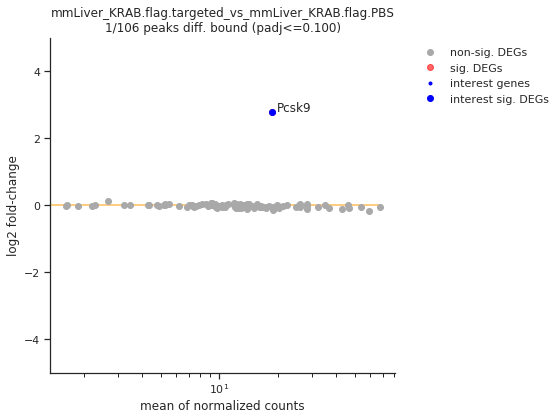

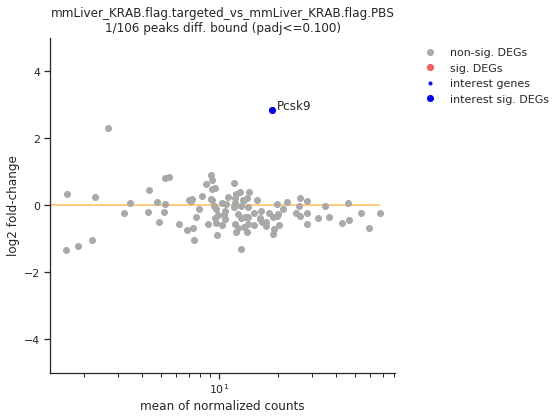

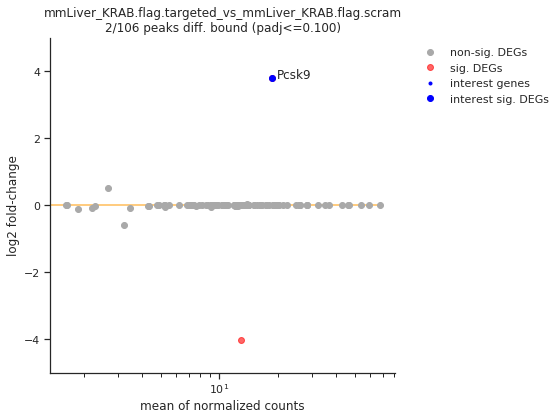

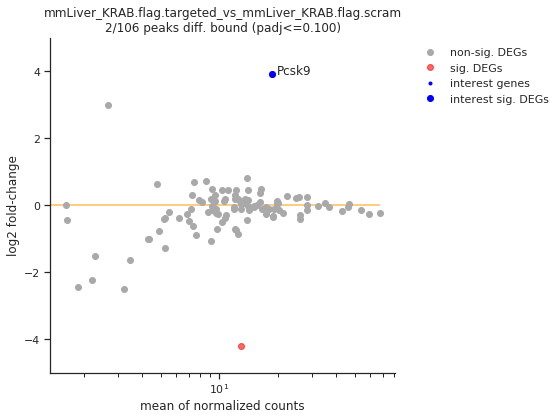

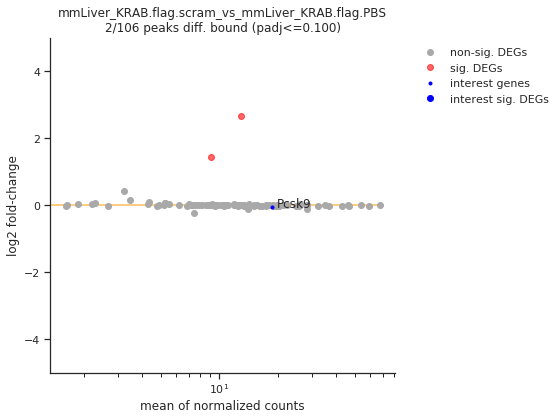

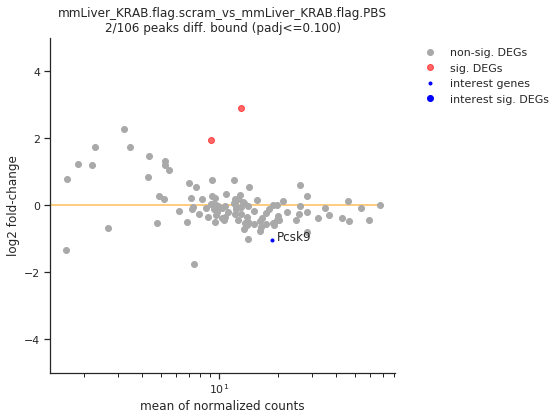

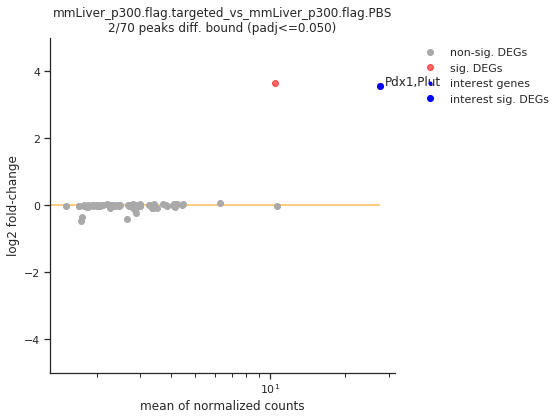

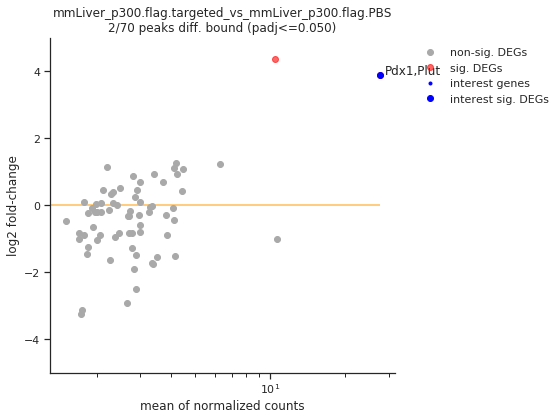

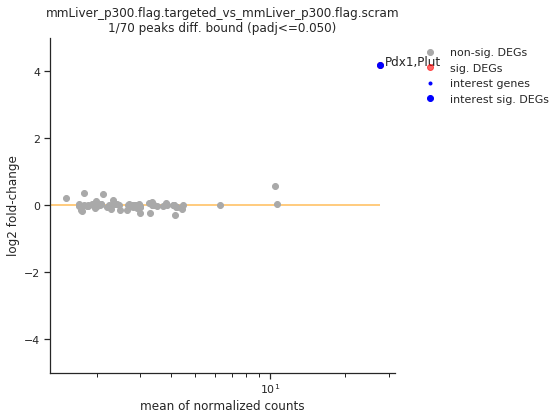

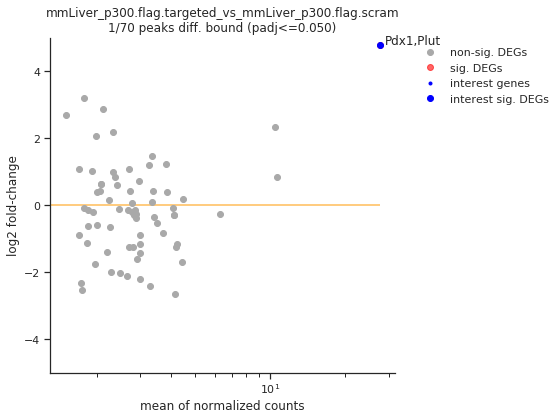

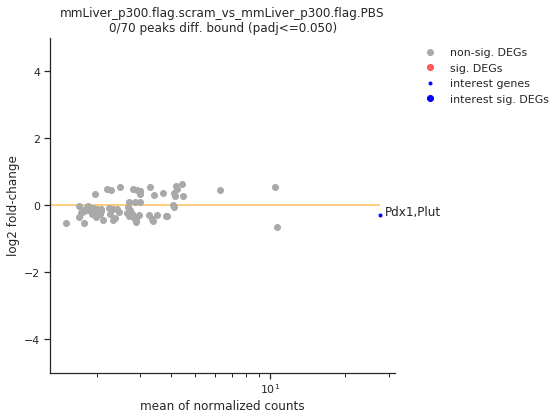

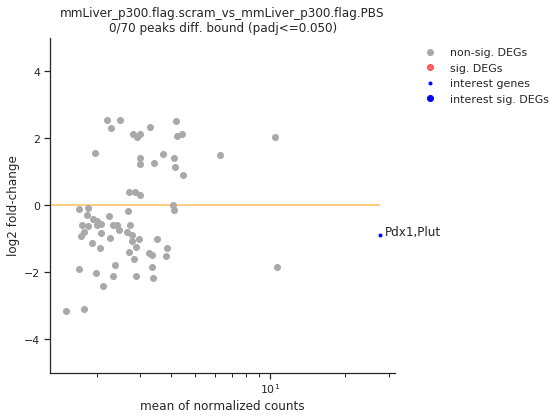

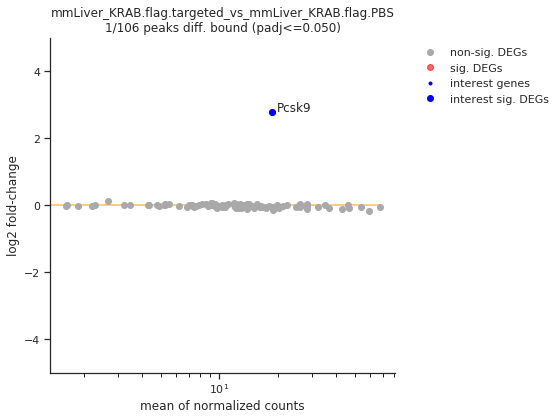

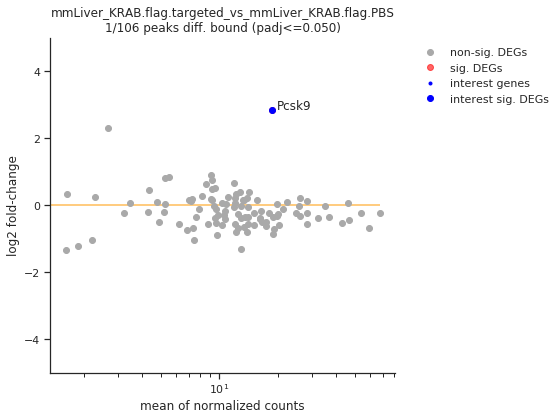

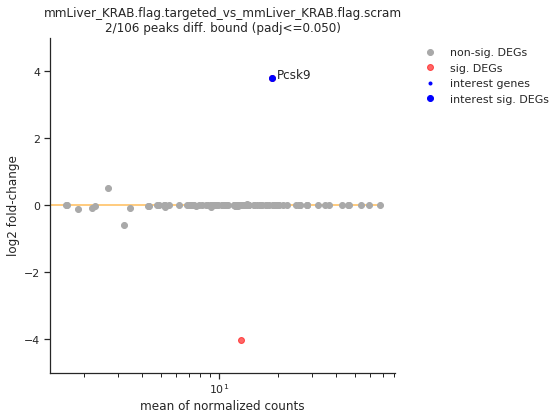

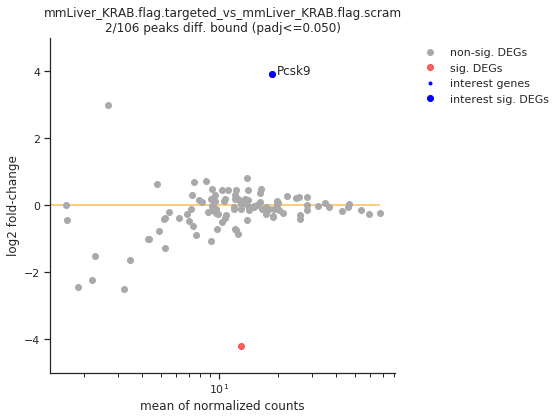

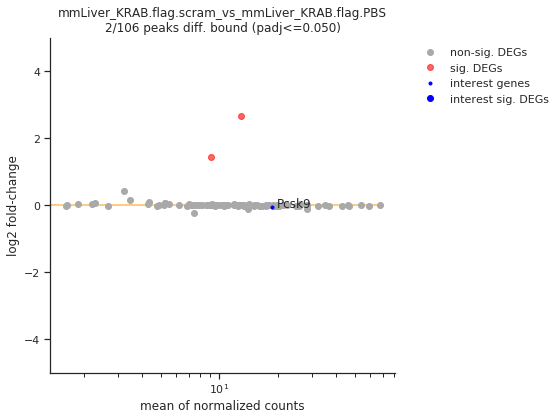

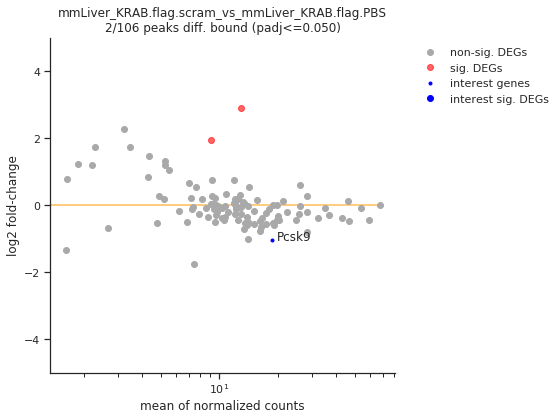

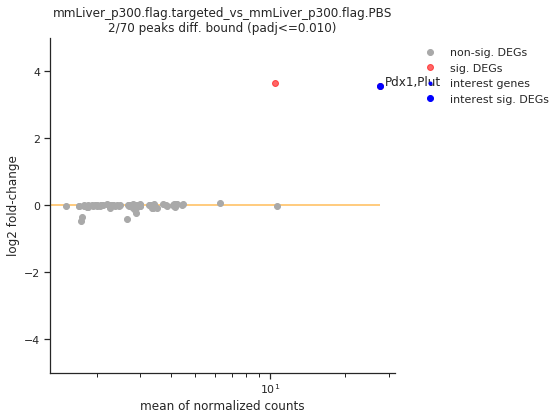

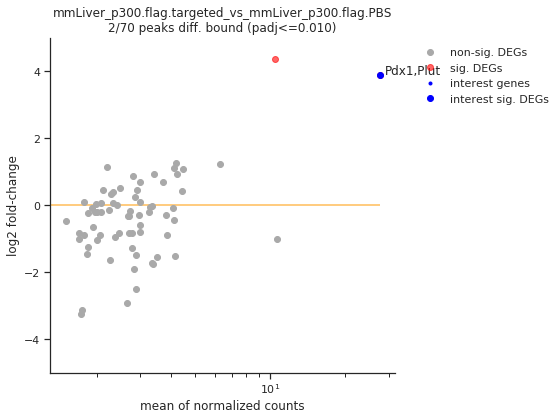

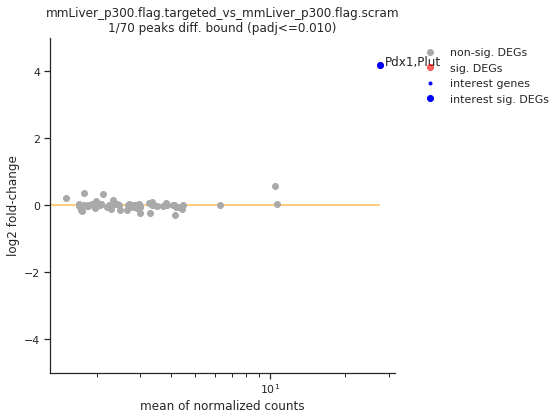

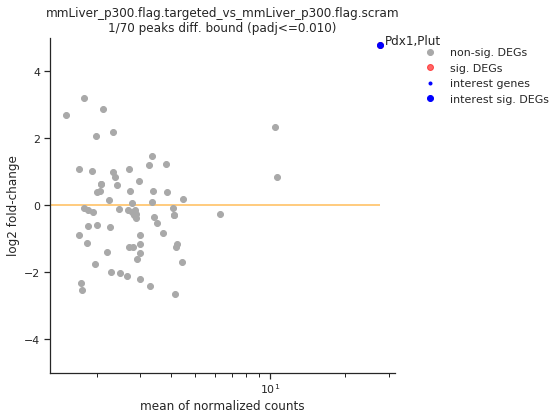

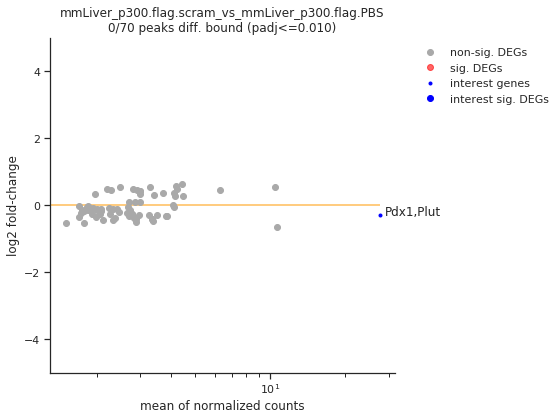

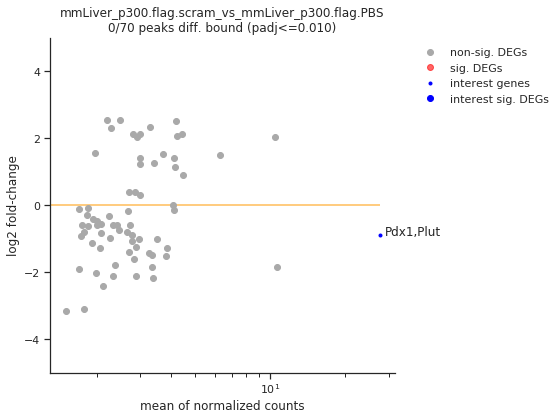

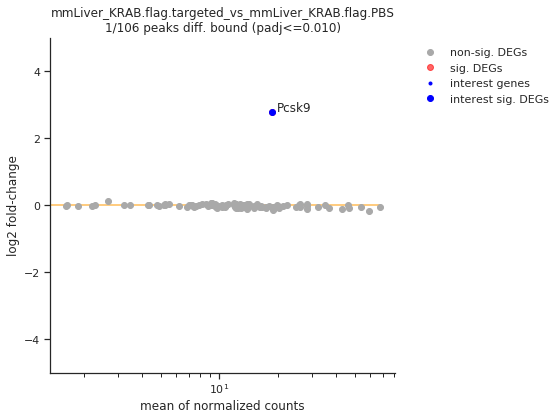

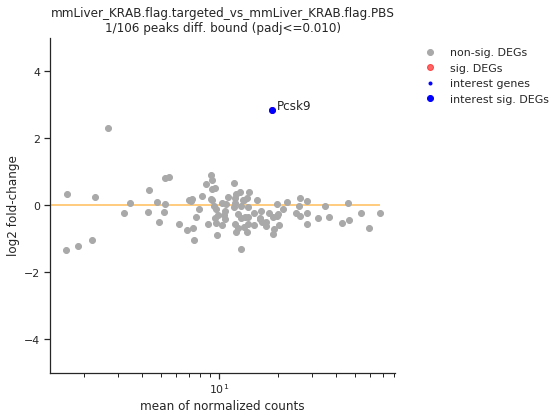

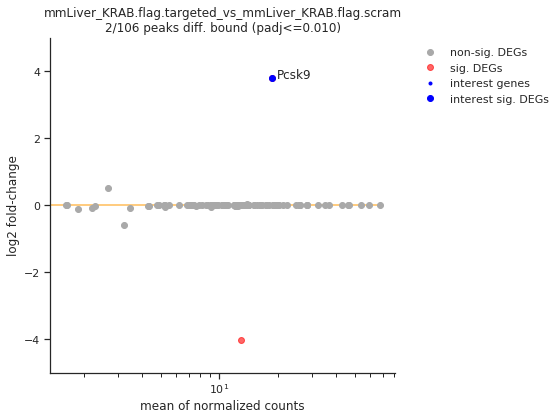

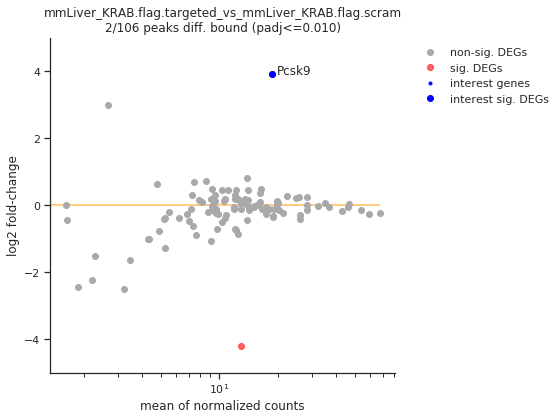

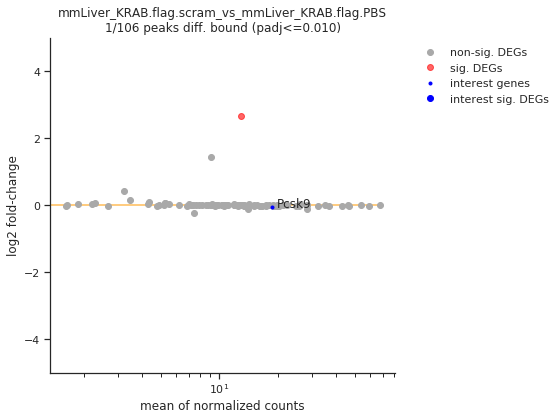

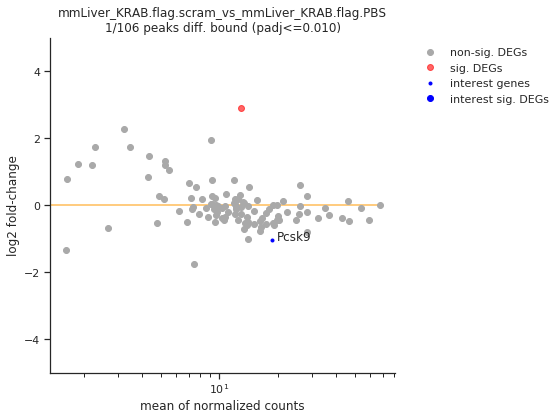

In [2]:
from IPython.display import display
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context("notebook")
plt.rcParams['pdf.fonttype'] = 42
sns.set_style("whitegrid")
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

# Config
pval_thres = 0.1
top_to_report = 4000
special_genes = ['Pdx1,Plut', 'Pcsk9']
comparisons = [
    "mmLiver_p300.flag.targeted_vs_mmLiver_p300.flag.PBS",
    "mmLiver_p300.flag.targeted_vs_mmLiver_p300.flag.scram",
    "mmLiver_p300.flag.scram_vs_mmLiver_p300.flag.PBS",
    "mmLiver_KRAB.flag.targeted_vs_mmLiver_KRAB.flag.PBS",
    "mmLiver_KRAB.flag.targeted_vs_mmLiver_KRAB.flag.scram",
    "mmLiver_KRAB.flag.scram_vs_mmLiver_KRAB.flag.PBS",
]

data_dir = '/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/differential_testing/deseq2/flags'
for pval_thres in [0.2, 0.1, 0.05, 0.01]:

    for comparison in comparisons:
        if 'p300' in comparison:
            special_genes = ['Pdx1,Plut']
        else:
            special_genes = ['Pcsk9']

        for shrinkage in ['', '.unshrunk']:
            df = pd.read_csv("%s/%s%s.with_closest_gene.txt" % (data_dir, comparison, shrinkage),
                            sep="\t", index_col=0)
            df.loc[df.padj.isna(), 'padj'] = 1
        #     df.loc[:, "genes"] = df.index
#             fig = plt.figure(figsize=(6, 3))#figsize=(12, 10))
            fig = plt.figure(figsize=(8, 6))
            ax = plt.subplot(1, 1, 1)
            df_non_sig = df[~(df.padj<pval_thres) & (~df.genes.isin(special_genes))]
            ax.set_xscale('log')
            ax.plot(df_non_sig['baseMean'].values, 
                    df_non_sig['log2FoldChange'].values, 
                    'o', color='darkgrey', label='non-sig. DEGs')

            ylims = [np.min([np.ceil(df['log2FoldChange'].min()-1), -5]), 
                     np.max([np.floor(df['log2FoldChange'].max()+1), 5])]
            df_sig = df[df.padj<=pval_thres]
            ax.plot(df_sig['baseMean'].values, df_sig['log2FoldChange'].values, 'ro', alpha=0.6, label='sig. DEGs')

            # Annotate the top top_to_report
            df_annotate = df_sig.sort_values(by='padj', ascending=True).head(top_to_report)

            # Annotate in particular IL1RN, HBG and EP300
            df_annotate_selected = df[df.genes.isin(special_genes)]
            ax.plot(df_annotate_selected['baseMean'].values, 
                    df_annotate_selected['log2FoldChange'].values,color='blue', 
                    marker='.', linestyle = 'None', alpha=1, label='interest genes')
            for x, y, t in zip(df_annotate_selected['baseMean'].values,
                               df_annotate_selected['log2FoldChange'].values, 
                               df_annotate_selected['genes'].values) :
                ax.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left',
                        textcoords='offset points')
            df_annotate_selected = df_sig[df_sig.genes.isin(special_genes)]
            ax.plot(df_annotate_selected['baseMean'].values, 
                    df_annotate_selected['log2FoldChange'].values,color='blue', 
                    marker='o', linestyle = 'None', alpha=1, label='interest sig. DEGs')

            plt.ylim(ylims)
            plt.xlabel("mean of normalized counts")
            plt.ylabel("log2 fold-change")
            plt.title("%s\n%d/%d peaks diff. bound (padj<=%.3f)" % (comparison, 
                                                                     np.count_nonzero(df.padj<=pval_thres),
                                                                        df.shape[0],
                                                                     pval_thres))
            plt.hlines(0, 0, df['baseMean'].max(), color='#ffcc80', linewidth =2 )

            # plot legend
            plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", frameon=False)

            # Remove spines and tight the layout
            simpleaxis(ax)
            plt.tight_layout()

            # Save annotated MA plot
    #         plt.savefig("%s/degs.%s%s.with_genes.annotated_plot_MA.pdf" % (data_dir, comparison, shrinkage))
            plt.savefig("%s/degs.%s%s.with_genes.annotated_plot_MA.fdr_%.2f.pdf" % (data_dir, comparison, shrinkage, pval_thres))

        #     # Save annotated genes without pseudogenes
        #     df_annotate.to_csv("/data/reddylab/Alex/collab/20180214_JoshBlack/results/rna_seq/degs%s.with_genes.sig_DE_no_pseudogenes.txt" % comparison,
        #                       sep='\t',
        #                       index=False)

            # print table of values 
            print "======", comparison, "======"
#             display(df_annotate)
    
   


Matt raised the point of maybe checking how the MA plots would look after sustracting the input control reads:

- [ ] Try DiffBind

In [45]:
%%bash
for FACTOR in p300.K27ac KRAB.K9me3;
do
    cut -f1-3 /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/peaks/mmLiver_${FACTOR}.union_peakset_no_input_plus_flag.bed \
    > /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/peaks/mmLiver_${FACTOR}.union_peakset_no_input_plus_flag.bed3
done


In [3]:
%%bash
mkdir -p /data/reddylab/Alex/collab/20190701_Matt/data/chip_seq/diffbind/
mkdir -p /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/diffbind/

In [25]:
%%writefile /data/reddylab/Alex/collab/20190701_Matt/data/chip_seq/metadata/diff_bind_sample_sheet.p300.csv
SampleID,Tissue,Factor,Condition,Replicate,bamReads,bamControl,Peaks,PeakCaller
mmLiver_p300.K27ac.targeted.rep6,Liver,p300.targeted,mmLiver_p300.K27ac.targeted,6,/data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/Matt_5756_190620B1-se-with-control/mmLiver_p300.K27ac.targeted.rep6.masked.dedup.sorted.bam,/data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/Matt_5756_190620B1-se-with-control/mmLiver_p300.input.targeted.rep6.masked.dedup.sorted.bam,/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/peaks/mmLiver_p300.K27ac.union_peakset_no_input_plus_flag.bed3,narrow
mmLiver_p300.K27ac.targeted.rep7,Liver,p300.targeted,mmLiver_p300.K27ac.targeted,7,/data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/Matt_5756_190620B1-se-with-control/mmLiver_p300.K27ac.targeted.rep7.masked.dedup.sorted.bam,/data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/Matt_5756_190620B1-se-with-control/mmLiver_p300.input.targeted.rep7.masked.dedup.sorted.bam,/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/peaks/mmLiver_p300.K27ac.union_peakset_no_input_plus_flag.bed3,narrow
mmLiver_p300.K27ac.targeted.rep8,Liver,p300.targeted,mmLiver_p300.K27ac.targeted,8,/data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/Matt_5756_190620B1-se-with-control/mmLiver_p300.K27ac.targeted.rep8.masked.dedup.sorted.bam,/data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/Matt_5756_190620B1-se-with-control/mmLiver_p300.input.targeted.rep8.masked.dedup.sorted.bam,/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/peaks/mmLiver_p300.K27ac.union_peakset_no_input_plus_flag.bed3,narrow
mmLiver_p300.K27ac.targeted.rep9,Liver,p300.targeted,mmLiver_p300.K27ac.targeted,9,/data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/Matt_5756_190620B1-se-with-control/mmLiver_p300.K27ac.targeted.rep9.masked.dedup.sorted.bam,/data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/Matt_5756_190620B1-se-with-control/mmLiver_p300.input.targeted.rep9.masked.dedup.sorted.bam,/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/peaks/mmLiver_p300.K27ac.union_peakset_no_input_plus_flag.bed3,narrow
mmLiver_p300.K27ac.scram.rep1,Liver,p300.scram,mmLiver_p300.K27ac.scram,1,/data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/Matt_5756_190620B1-se-with-control/mmLiver_p300.K27ac.scram.rep1.masked.dedup.sorted.bam,/data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/Matt_5756_190620B1-se-with-control/mmLiver_p300.input.scram.rep1.masked.dedup.sorted.bam,/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/peaks/mmLiver_p300.K27ac.union_peakset_no_input_plus_flag.bed3,narrow
mmLiver_p300.K27ac.scram.rep2,Liver,p300.scram,mmLiver_p300.K27ac.scram,2,/data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/Matt_5756_190620B1-se-with-control/mmLiver_p300.K27ac.scram.rep2.masked.dedup.sorted.bam,/data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/Matt_5756_190620B1-se-with-control/mmLiver_p300.input.scram.rep2.masked.dedup.sorted.bam,/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/peaks/mmLiver_p300.K27ac.union_peakset_no_input_plus_flag.bed3,narrow
mmLiver_p300.K27ac.scram.rep3,Liver,p300.scram,mmLiver_p300.K27ac.scram,3,/data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/Matt_5756_190620B1-se-with-control/mmLiver_p300.K27ac.scram.rep3.masked.dedup.sorted.bam,/data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/Matt_5756_190620B1-se-with-control/mmLiver_p300.input.scram.rep3.masked.dedup.sorted.bam,/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/peaks/mmLiver_p300.K27ac.union_peakset_no_input_plus_flag.bed3,narrow
mmLiver_p300.K27ac.scram.rep5,Liver,p300.scram,mmLiver_p300.K27ac.scram,5,/data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/Matt_5756_190620B1-se-with-control/mmLiver_p300.K27ac.scram.rep5.masked.dedup.sorted.bam,/data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/Matt_5756_190620B1-se-with-control/mmLiver_p300.input.scram.rep5.masked.dedup.sorted.bam,/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/peaks/mmLiver_p300.K27ac.union_peakset_no_input_plus_flag.bed3,narrow
mmLiver_p300.K27ac.PBS.rep10,Liver,p300.PBS,mmLiver_p300.K27ac.PBS,10,/data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/Matt_5756_190620B1-se-with-control/mmLiver_p300.K27ac.PBS.rep10.masked.dedup.sorted.bam,/data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/Matt_5756_190620B1-se-with-control/mmLiver_p300.input.PBS.rep10.masked.dedup.sorted.bam,/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/peaks/mmLiver_p300.K27ac.union_peakset_no_input_plus_flag.bed3,narrow
mmLiver_p300.K27ac.PBS.rep11,Liver,p300.PBS,mmLiver_p300.K27ac.PBS,11,/data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/Matt_5756_190620B1-se-with-control/mmLiver_p300.K27ac.PBS.rep11.masked.dedup.sorted.bam,/data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/Matt_5756_190620B1-se-with-control/mmLiver_p300.input.PBS.rep11.masked.dedup.sorted.bam,/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/peaks/mmLiver_p300.K27ac.union_peakset_no_input_plus_flag.bed3,narrow
mmLiver_p300.K27ac.PBS.rep12,Liver,p300.PBS,mmLiver_p300.K27ac.PBS,12,/data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/Matt_5756_190620B1-se-with-control/mmLiver_p300.K27ac.PBS.rep12.masked.dedup.sorted.bam,/data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/Matt_5756_190620B1-se-with-control/mmLiver_p300.input.PBS.rep12.masked.dedup.sorted.bam,/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/peaks/mmLiver_p300.K27ac.union_peakset_no_input_plus_flag.bed3,narrow
mmLiver_p300.K27ac.PBS.rep4,Liver,p300.PBS,mmLiver_p300.K27ac.PBS,4,/data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/Matt_5756_190620B1-se-with-control/mmLiver_p300.K27ac.PBS.rep4.masked.dedup.sorted.bam,/data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/Matt_5756_190620B1-se-with-control/mmLiver_p300.input.PBS.rep4.masked.dedup.sorted.bam,/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/peaks/mmLiver_p300.K27ac.union_peakset_no_input_plus_flag.bed3,narrow


Overwriting /data/reddylab/Alex/collab/20190701_Matt/data/chip_seq/metadata/diff_bind_sample_sheet.p300.csv


In [24]:
%%writefile /data/reddylab/Alex/collab/20190701_Matt/data/chip_seq/metadata/diff_bind_sample_sheet.KRAB.csv
SampleID,Tissue,Factor,Condition,Replicate,bamReads,bamControl,Peaks,PeakCaller
mmLiver_KRAB.K9me3.targeted.rep3,Liver,K9me3.targeted,mmLiver_KRAB.K9me3.targeted,3,/data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/Matt_5756_190620B1-se-with-control/mmLiver_KRAB.K9me3.targeted.rep3.masked.dedup.sorted.bam,/data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/Matt_5756_190620B1-se-with-control/mmLiver_KRAB.Input.targeted.rep3.masked.dedup.sorted.bam,/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/peaks/mmLiver_KRAB.K9me3.union_peakset_no_input_plus_flag.bed3,broad
mmLiver_KRAB.K9me3.targeted.rep5,Liver,K9me3.targeted,mmLiver_KRAB.K9me3.targeted,5,/data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/Matt_5756_190620B1-se-with-control/mmLiver_KRAB.K9me3.targeted.rep5.masked.dedup.sorted.bam,/data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/Matt_5756_190620B1-se-with-control/mmLiver_KRAB.Input.targeted.rep5.masked.dedup.sorted.bam,/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/peaks/mmLiver_KRAB.K9me3.union_peakset_no_input_plus_flag.bed3,broad
mmLiver_KRAB.K9me3.targeted.rep6,Liver,K9me3.targeted,mmLiver_KRAB.K9me3.targeted,6,/data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/Matt_5756_190620B1-se-with-control/mmLiver_KRAB.K9me3.targeted.rep6.masked.dedup.sorted.bam,/data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/Matt_5756_190620B1-se-with-control/mmLiver_KRAB.Input.targeted.rep6.masked.dedup.sorted.bam,/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/peaks/mmLiver_KRAB.K9me3.union_peakset_no_input_plus_flag.bed3,broad
mmLiver_KRAB.K9me3.targeted.rep7,Liver,K9me3.targeted,mmLiver_KRAB.K9me3.targeted,7,/data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/Matt_5756_190620B1-se-with-control/mmLiver_KRAB.K9me3.targeted.rep7.masked.dedup.sorted.bam,/data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/Matt_5756_190620B1-se-with-control/mmLiver_KRAB.Input.targeted.rep7.masked.dedup.sorted.bam,/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/peaks/mmLiver_KRAB.K9me3.union_peakset_no_input_plus_flag.bed3,broad
mmLiver_KRAB.K9me3.scram.rep10,Liver,K9me3.scram,mmLiver_KRAB.K9me3.scram,10,/data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/Matt_5756_190620B1-se-with-control/mmLiver_KRAB.K9me3.scram.rep10.masked.dedup.sorted.bam,/data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/Matt_5756_190620B1-se-with-control/mmLiver_KRAB.Input.scram.rep10.masked.dedup.sorted.bam,/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/peaks/mmLiver_KRAB.K9me3.union_peakset_no_input_plus_flag.bed3,broad
mmLiver_KRAB.K9me3.scram.rep11,Liver,K9me3.scram,mmLiver_KRAB.K9me3.scram,11,/data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/Matt_5756_190620B1-se-with-control/mmLiver_KRAB.K9me3.scram.rep11.masked.dedup.sorted.bam,/data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/Matt_5756_190620B1-se-with-control/mmLiver_KRAB.Input.scram.rep11.masked.dedup.sorted.bam,/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/peaks/mmLiver_KRAB.K9me3.union_peakset_no_input_plus_flag.bed3,broad
mmLiver_KRAB.K9me3.scram.rep8,Liver,K9me3.scram,mmLiver_KRAB.K9me3.scram,8,/data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/Matt_5756_190620B1-se-with-control/mmLiver_KRAB.K9me3.scram.rep8.masked.dedup.sorted.bam,/data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/Matt_5756_190620B1-se-with-control/mmLiver_KRAB.Input.scram.rep8.masked.dedup.sorted.bam,/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/peaks/mmLiver_KRAB.K9me3.union_peakset_no_input_plus_flag.bed3,broad
mmLiver_KRAB.K9me3.scram.rep9,Liver,K9me3.scram,mmLiver_KRAB.K9me3.scram,9,/data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/Matt_5756_190620B1-se-with-control/mmLiver_KRAB.K9me3.scram.rep9.masked.dedup.sorted.bam,/data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/Matt_5756_190620B1-se-with-control/mmLiver_KRAB.Input.scram.rep9.masked.dedup.sorted.bam,/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/peaks/mmLiver_KRAB.K9me3.union_peakset_no_input_plus_flag.bed3,broad
mmLiver_KRAB.K9me3.PBS.rep12,Liver,K9me3.PBS,mmLiver_KRAB.K9me3.PBS,12,/data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/Matt_5756_190620B1-se-with-control/mmLiver_KRAB.K9me3.PBS.rep12.masked.dedup.sorted.bam,/data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/Matt_5756_190620B1-se-with-control/mmLiver_KRAB.Input.PBS.rep12.masked.dedup.sorted.bam,/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/peaks/mmLiver_KRAB.K9me3.union_peakset_no_input_plus_flag.bed3,broad
mmLiver_KRAB.K9me3.PBS.rep1,Liver,K9me3.PBS,mmLiver_KRAB.K9me3.PBS,1,/data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/Matt_5756_190620B1-se-with-control/mmLiver_KRAB.K9me3.PBS.rep1.masked.dedup.sorted.bam,/data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/Matt_5756_190620B1-se-with-control/mmLiver_KRAB.Input.PBS.rep1.masked.dedup.sorted.bam,/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/peaks/mmLiver_KRAB.K9me3.union_peakset_no_input_plus_flag.bed3,broad
mmLiver_KRAB.K9me3.PBS.rep2,Liver,K9me3.PBS,mmLiver_KRAB.K9me3.PBS,2,/data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/Matt_5756_190620B1-se-with-control/mmLiver_KRAB.K9me3.PBS.rep2.masked.dedup.sorted.bam,/data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/Matt_5756_190620B1-se-with-control/mmLiver_KRAB.Input.PBS.rep2.masked.dedup.sorted.bam,/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/peaks/mmLiver_KRAB.K9me3.union_peakset_no_input_plus_flag.bed3,broad
mmLiver_KRAB.K9me3.PBS.rep4,Liver,K9me3.PBS,mmLiver_KRAB.K9me3.PBS,4,/data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/Matt_5756_190620B1-se-with-control/mmLiver_KRAB.K9me3.PBS.rep4.masked.dedup.sorted.bam,/data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/Matt_5756_190620B1-se-with-control/mmLiver_KRAB.Input.PBS.rep4.masked.dedup.sorted.bam,/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/peaks/mmLiver_KRAB.K9me3.union_peakset_no_input_plus_flag.bed3,broad


Overwriting /data/reddylab/Alex/collab/20190701_Matt/data/chip_seq/metadata/diff_bind_sample_sheet.KRAB.csv


In [19]:
%%writefile /data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/scripts/diffbind.extract_counts.p300.R
#!/bin/env/R
library(DiffBind)
DBA <- dba(sampleSheet='/data/reddylab/Alex/collab/20190701_Matt/data/chip_seq/metadata/diff_bind_sample_sheet.p300.csv')
DBA$config$yieldSize <- 50000
DBA <- dba.count(DBA, 
                 peaks='/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/peaks/mmLiver_p300.K27ac.union_peakset_no_input_plus_flag.bed3',
                 score=DBA_SCORE_TMM_MINUS_EFFECTIVE,
                 bParallel=F)
# DBA <- dba.contrast(DBA, categories=c(DBA_CONDITION))
# DBA <- dba.analyze(DBA, method=DBA_DESEQ2, bParallel=FALSE)
dba.save(DBA, 
         file='DBA', 
         dir='/data/reddylab/Alex/collab/20190701_Matt/data/chip_seq/diffbind/', 
         pre='dba_p300_', 
         ext='RData', 
         bMinimize=FALSE)



Overwriting /data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/scripts/diffbind.extract_counts.p300.R


In [20]:
%%writefile /data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/scripts/diffbind.extract_counts.KRAB.R
#!/bin/env/R
library(DiffBind)
DBA <- dba(sampleSheet='/data/reddylab/Alex/collab/20190701_Matt/data/chip_seq/metadata/diff_bind_sample_sheet.KRAB.csv')
DBA$config$yieldSize <- 50000
DBA <- dba.count(DBA, 
                 peaks='/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/peaks/mmLiver_KRAB.K9me3.union_peakset_no_input_plus_flag.bed3',
                 score=DBA_SCORE_TMM_MINUS_EFFECTIVE,
                 bParallel=F)
        
# DBA <- dba.contrast(DBA, categories=c(DBA_CONDITION))
# DBA <- dba.analyze(DBA, method=DBA_DESEQ2, bParallel=FALSE)
dba.save(DBA, 
         file='DBA', 
         dir='/data/reddylab/Alex/collab/20190701_Matt/data/chip_seq/diffbind/', 
         pre='dba_KRAB_', 
         ext='RData', 
         bMinimize=FALSE)


Overwriting /data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/scripts/diffbind.extract_counts.KRAB.R


In [21]:
%%script --out dba_1 bash
source /data/reddylab/software/miniconda2/bin/activate alex_dev

sbatch \
    -o /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/logs/diffbind.extract_counts.KRAB.out \
    -pnew,all \
    --mem=32G \
    <<'EOF'
#!/bin/bash
Rscript /data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/scripts/diffbind.extract_counts.KRAB.R
EOF

sbatch \
    -o /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/logs/diffbind.extract_counts.p300.out \
    -pnew,all \
    --mem=32G \
    <<'EOF'
#!/bin/bash
Rscript /data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/scripts/diffbind.extract_counts.p300.R
EOF


In [27]:
%%writefile /data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/scripts/diffbind.analysis.p300.R
#!/bin/env/R
library(DiffBind)
DBA <- dba.load(
    file='DBA', 
    dir='/data/reddylab/Alex/collab/20190701_Matt/data/chip_seq/diffbind/', 
    pre='dba_p300_', 
    ext='RData')

DBA$contrasts=NULL
targeted_mask <- dba.mask(DBA, DBA_CONDITION, 'mmLiver_p300.K27ac.targeted')
scram_mask <- dba.mask(DBA, DBA_CONDITION, 'mmLiver_p300.K27ac.scram')
PBS_mask <- dba.mask(DBA, DBA_CONDITION, 'mmLiver_p300.K27ac.PBS')

# FLAG
DBA <- dba.contrast(DBA, group1=targeted_mask, name1='Pdx1', group2=scram_mask, name2='scram')
DBA <- dba.contrast(DBA, group1=targeted_mask, name1='Pdx1', group2=PBS_mask, name2='PBS')
DBA <- dba.contrast(DBA, group1=scram_mask, name1='scram', group2=PBS_mask, name2='PBS')

DBA <- dba.analyze(DBA, method=c(DBA_DESEQ2,DBA_EDGER), bParallel=FALSE)
dba.save(DBA, 
         file='DBA_analyzed', 
         dir='/data/reddylab/Alex/collab/20190701_Matt/data/chip_seq/diffbind/',
         pre='dba_p300_', 
         ext='RData', bMinimize=FALSE)



Overwriting /data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/scripts/diffbind.analysis.p300.R


In [28]:
%%writefile /data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/scripts/diffbind.analysis.KRAB.R
#!/bin/env/R
library(DiffBind)
DBA <- dba.load(
    file='DBA', 
    dir='/data/reddylab/Alex/collab/20190701_Matt/data/chip_seq/diffbind/', 
    pre='dba_KRAB_', 
    ext='RData')

DBA$contrasts=NULL
targeted_mask <- dba.mask(DBA, DBA_CONDITION, 'mmLiver_KRAB.K9me3.targeted')
scram_mask <- dba.mask(DBA, DBA_CONDITION, 'mmLiver_KRAB.K9me3.scram')
PBS_mask <- dba.mask(DBA, DBA_CONDITION, 'mmLiver_KRAB.K9me3.PBS')

# FLAG
DBA <- dba.contrast(DBA, group1=targeted_mask, name1='Pcsk9', group2=scram_mask, name2='scram')
DBA <- dba.contrast(DBA, group1=targeted_mask, name1='Pcsk9', group2=PBS_mask, name2='PBS')
DBA <- dba.contrast(DBA, group1=scram_mask, name1='scram', group2=PBS_mask, name2='PBS')

DBA <- dba.analyze(DBA, method=c(DBA_DESEQ2,DBA_EDGER), bParallel=FALSE)
dba.save(DBA, 
         file='DBA_analyzed', 
         dir='/data/reddylab/Alex/collab/20190701_Matt/data/chip_seq/diffbind/',
         pre='dba_KRAB_', 
         ext='RData', bMinimize=FALSE)



Overwriting /data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/scripts/diffbind.analysis.KRAB.R


In [ ]:
DBA <- dba.load(file='DBA_analyzed', dir='/data/reddylab/Alex/collab/20190701_Matt/data/chip_seq/diffbind/',pre='dba_p300_', ext='RData')

In [25]:
%%script --out dba_1 bash
source /data/reddylab/software/miniconda2/bin/activate alex_dev

sbatch \
    -o /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/logs/diffbind.analysis.KRAB.out \
    -pnew,all \
    --mem=32G \
    <<'EOF'
#!/bin/bash
Rscript /data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/scripts/diffbind.analysis.KRAB.R
EOF

sbatch \
    --depend=afterok:10214619 \
    -o /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/logs/diffbind.analysis.p300.out \
    -pnew,all \
    --mem=32G \
    <<'EOF'
#!/bin/bash
Rscript /data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/scripts/diffbind.analysis.p300.R
EOF


In [50]:
dba_1

'Submitted batch job 10184115\nSubmitted batch job 10184116\n'

In [26]:
%%writefile /data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/scripts/diffbind.summary_and_plotting.p300.R
#!/bin/env/R
library(DiffBind)


(DBA <- dba.load(file='DBA_analyzed', 
                 dir='/data/reddylab/Alex/collab/20190701_Matt/data/chip_seq/diffbind/',
                 pre='dba_p300_', 
                 ext='RData'))

# Save counts
peakset <- dba.peakset(DBA, bRetrieve=TRUE, DataType=DBA_DATA_FRAME)
write.table(peakset, 
            "/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/diffbind/counts.TMM_MINUS_EFFECTIVE.p300.K27ac.txt", 
            col.names=T, 
            sep='\t', 
            quote=F)

generate_db_report <- 
    function(n, d, gns, th=1, ...){
        db_report <- dba.report(d, n, th=th, bUsePval=FALSE, method=DBA_EDGER)
        treat_vs_contr <- paste0(d$contrast[[n]]$name1, '_', d$contrast[[n]]$name2)
        treat_vs_contr
        # Save results in tab-delimited file
        write.table(as.data.frame(db_report), 
            file=paste0('/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/diffbind/', treat_vs_contr, '.diffBind.txt'),
            quote = FALSE, row.names=FALSE, sep = "\t")
        treat_vs_contr
        
        # Create MA plot
        pdf(paste0('/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/diffbind/', treat_vs_contr, '.diffBind_MA.pdf'))
        dba.plotMA(DBA, contrast=n, bNormalized=FALSE)
        dev.off()

        # Plot correlation heatmap
        pdf(paste0('/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/diffbind/', treat_vs_contr, '.diffBind_corr.pdf'))
        dba.plotHeatmap(DBA, contrast=n, bNormalized=FALSE)
        dev.off()
        
    }

# plot correlation heatmap
pdf(paste0('/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/diffbind/diffBind_corr.pdf'))
plot(DBA)
dev.off()

    
dd <- lapply(seq(1,  length(DBA$contrasts)), generate_db_report, DBA, gns)



Overwriting /data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/scripts/diffbind.summary_and_plotting.p300.R


In [27]:
%%writefile /data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/scripts/diffbind.summary_and_plotting.KRAB.R
#!/bin/env/R
library(DiffBind)


(DBA <- dba.load(file='DBA_analyzed', 
                 dir='/data/reddylab/Alex/collab/20190701_Matt/data/chip_seq/diffbind/',
                 pre='dba_KRAB_', 
                 ext='RData'))
# Save counts
peakset <- dba.peakset(DBA, bRetrieve=TRUE, DataType=DBA_DATA_FRAME)
write.table(peakset, 
            "/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/diffbind/counts.TMM_MINUS_EFFECTIVE.KRAB.K9me3.txt", 
            col.names=T, 
            sep='\t', 
            quote=F)

generate_db_report <- 
    function(n, d, gns, th=1, ...){
        db_report <- dba.report(d, n, th=th, bUsePval=FALSE, method=DBA_EDGER)
        treat_vs_contr <- paste0(d$contrast[[n]]$name1, '_', d$contrast[[n]]$name2)
        treat_vs_contr
        # Save results in tab-delimited file
        write.table(as.data.frame(db_report), 
            file=paste0('/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/diffbind/', treat_vs_contr, '.diffBind.txt'),
            quote = FALSE, row.names=FALSE, sep = "\t")
        treat_vs_contr
        
        # Create MA plot
        pdf(paste0('/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/diffbind/', treat_vs_contr, '.diffBind_MA.pdf'))
        dba.plotMA(DBA, contrast=n, bNormalized=FALSE)
        dev.off()

        # Plot correlation heatmap
        pdf(paste0('/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/diffbind/', treat_vs_contr, '.diffBind_corr.pdf'))
        dba.plotHeatmap(DBA, contrast=n, bNormalized=FALSE)
        dev.off()
        
    }

# plot correlation heatmap
pdf(paste0('/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/diffbind/diffBind_corr.pdf'))
plot(DBA)
dev.off()

    
dd <- lapply(seq(1,  length(DBA$contrasts)), generate_db_report, DBA, gns)



Overwriting /data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/scripts/diffbind.summary_and_plotting.KRAB.R


In [28]:
%%script --out dba_1 bash
source /data/reddylab/software/miniconda2/bin/activate alex_dev

sbatch \
    -o /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/logs/diffbind.summary_and_plotting.KRAB.out \
    -pnew,all \
    --mem=32G \
    <<'EOF'
#!/bin/bash
Rscript /data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/scripts/diffbind.summary_and_plotting.KRAB.R
EOF

sbatch \
    --depend=afterok:10215829 \
    -o /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/logs/diffbind.summary_and_plotting.p300.out \
    -pnew,all \
    --mem=32G \
    <<'EOF'
#!/bin/bash
Rscript /data/reddylab/Alex/collab/20190701_Matt/processing/chip_seq/scripts/diffbind.summary_and_plotting.p300.R
EOF


In [29]:
import pandas as pd
for factor in ["p300.K27ac", "KRAB.K9me3"]:
    df = pd.read_csv('/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/diffbind/counts.TMM_MINUS_EFFECTIVE.%s.txt' % factor,
                    sep="\t")
    df.index = df.apply(lambda x: "%s_%s_%s" % (x[0], x[1], x[2]), axis=1)
    df.astype(int, errors='ignore')\
    .to_csv('/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/diffbind/counts.TMM_MINUS_EFFECTIVE.%s.df.txt' % factor,
            sep="\t")

In [2]:
import pandas as pd
for factor in ["p300.K27ac", "KRAB.K9me3"]:
    df = pd.read_csv('/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/diffbind/counts.TMM_MINUS_FULL.%s.txt' % factor,
                    sep="\t")
    df.index = df.apply(lambda x: "%s_%s_%s" % (x[0], x[1], x[2]), axis=1)
    df.astype(int, errors='ignore')\
    .to_csv('/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/diffbind/counts.TMM_MINUS_FULL.%s.df.txt' % factor,
            sep="\t")

Use DESeq2 with TMM_MINUS_EFFECTIVE 

In [40]:
%%bash
mkdir -p /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/differential_testing/deseq2/tmms/effective_lib_size
source /data/reddylab/software/miniconda2/bin/activate alex_dev
sbatch -pnew,all \
    -x $(cat /home/aeb84/.slurm_exclude_list.txt) \
    --array=0-5 \
    --mem 16G \
    -o /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/logs/chipseq_deseq2.mmLiver.tmms.effective_lib_size.%a.out \
    <<'EOF'
#!/bin/bash
COMPARISONS=( \
    mmLiver_p300.K27ac.targeted-mmLiver_p300.K27ac.PBS \
    mmLiver_p300.K27ac.targeted-mmLiver_p300.K27ac.scram \
    mmLiver_p300.K27ac.scram-mmLiver_p300.K27ac.PBS \
    mmLiver_KRAB.K9me3.targeted-mmLiver_KRAB.K9me3.PBS \
    mmLiver_KRAB.K9me3.targeted-mmLiver_KRAB.K9me3.scram \
    mmLiver_KRAB.K9me3.scram-mmLiver_KRAB.K9me3.PBS \
)

COMPARISON=${COMPARISONS[${SLURM_ARRAY_TASK_ID}]}
TREAT=$(echo $COMPARISON | cut -d"-" -f1)
CONTROL=$(echo $COMPARISON | cut -d"-" -f2)
FACTOR=$(echo ${CONTROL} | cut -d. -f1-2 | cut -d_ -f2-)
#     --lib-sizes /data/reddylab/Alex/collab/20190701_Matt/data/chip_seq/lib_sizes/Matt_5756_190620B1.all.lib_sizes.txt \

Rscript /data/reddylab/Alex/reddylab_utils/scripts/de.deseq2.R \
    --counts-skip-ncols 3 \
    --no-filter \
    --lfcShrink ashr \
    --no-model-reps \
    --treatments \
        $( head -n1 /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/counts/mmLiver_${FACTOR}.union_peakset_no_input_plus_flag.featureCounts.df.txt | tr '\t' '\n' | /bin/grep ${TREAT}) \
    --controls \
        $( head -n1 /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/counts/mmLiver_${FACTOR}.union_peakset_no_input_plus_flag.featureCounts.df.txt | tr '\t' '\n' | /bin/grep ${CONTROL}) \
    --outdir /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/differential_testing/deseq2/tmms/effective_lib_size \
    --counts /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/diffbind/counts.TMM_MINUS_EFFECTIVE.${FACTOR}.df.txt

EOF


Submitted batch job 10218089


Use DESeq2 with TMM_MINUS_FULL 

In [12]:
%%bash
mkdir -p /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/differential_testing/deseq2/tmms/full_lib_size
source /data/reddylab/software/miniconda2/bin/activate alex_dev
sbatch -pnew,all \
    -x $(cat /home/aeb84/.slurm_exclude_list.txt) \
    --array=0-5 \
    --mem 16G \
    -o /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/logs/chipseq_deseq2.mmLiver.tmms.full_lib_size.%a.out \
    <<'EOF'
#!/bin/bash
COMPARISONS=( \
    mmLiver_p300.K27ac.targeted-mmLiver_p300.K27ac.PBS \
    mmLiver_p300.K27ac.targeted-mmLiver_p300.K27ac.scram \
    mmLiver_p300.K27ac.scram-mmLiver_p300.K27ac.PBS \
    mmLiver_KRAB.K9me3.targeted-mmLiver_KRAB.K9me3.PBS \
    mmLiver_KRAB.K9me3.targeted-mmLiver_KRAB.K9me3.scram \
    mmLiver_KRAB.K9me3.scram-mmLiver_KRAB.K9me3.PBS \
)

COMPARISON=${COMPARISONS[${SLURM_ARRAY_TASK_ID}]}
TREAT=$(echo $COMPARISON | cut -d"-" -f1)
CONTROL=$(echo $COMPARISON | cut -d"-" -f2)
FACTOR=$(echo ${CONTROL} | cut -d. -f1-2 | cut -d_ -f2-)
#     --lib-sizes /data/reddylab/Alex/collab/20190701_Matt/data/chip_seq/lib_sizes/Matt_5756_190620B1.all.lib_sizes.txt \

#     --no-filter \
Rscript /data/reddylab/Alex/reddylab_utils/scripts/de.deseq2.R \
    --counts-skip-ncols 3 \
    --lfcShrink ashr \
    --no-model-reps \
    --treatments \
        $( head -n1 /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/counts/mmLiver_${FACTOR}.union_peakset_no_input_plus_flag.featureCounts.df.txt | tr '\t' '\n' | /bin/grep ${TREAT}) \
    --controls \
        $( head -n1 /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/counts/mmLiver_${FACTOR}.union_peakset_no_input_plus_flag.featureCounts.df.txt | tr '\t' '\n' | /bin/grep ${CONTROL}) \
    --outdir /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/differential_testing/deseq2/tmms/full_lib_size \
    --counts /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/diffbind/counts.TMM_MINUS_FULL.${FACTOR}.df.txt

EOF


Submitted batch job 10220624


Annotate peaks with closest genes

In [32]:
%%bash
cd /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/diffbind

SAMPLES=($(/bin/ls -1 *_{PBS,scram}.diffBind.txt))
sbatch -pnew,all \
    --array=0-$((${#SAMPLES[@]}-1)) \
    --cpus-per-task 1 \
    --mem 4G \
    -o /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/logs/chipseq_diffbind.mmLiver.add_closest_gene.%a.out \
    <<'EOF'
#!/bin/bash

SAMPLES=($(/bin/ls -1 *_{PBS,scram}.diffBind.txt))
SAMPLE=${SAMPLES[${SLURM_ARRAY_TASK_ID}]}

tail -n+2 ${SAMPLE} \
| sort -k1,1 -k2,2n \
| bedtools closest \
    -wa \
    -nonamecheck \
    -D a \
    -a - \
    -b /data/reddylab/Reference_Data/Gencode/vM19/gencode.vM19.basic.annotation.bed \
| awk -vOFS="\t" \
    '{if(last==$1"_"$2"_"$3){genes=$18","genes;}else{if(genes){print peak, genes, distance}peak=$1"_"$2"_"$3; genes=$18; distance=$20; last=peak}}END{if(last==$1"_"$2"_"$3){genes=$18","genes;print peak, genes, distance}}' \
> ${SAMPLE/.txt/.closest_gene.txt}



EOF

Submitted batch job 10218044


Add closest gene info to DESeq2 results

In [33]:
import pandas as pd
samples = [
    "Pcsk9_scram",
    "Pdx1_PBS",
    "Pdx1_scram", 
    "scram_PBS",
]
data_dir = '/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/diffbind'
for sample in samples:
    for shrinkage in ['.diffBind']:
        df = pd.read_csv("%s/%s%s.txt" % (data_dir, sample, shrinkage), sep='\t')
        df.index = df.apply(lambda x: "%s_%s_%s" % (x[0], x[1], x[2]), axis=1)
        df_closest= pd.read_csv("%s/%s%s.closest_gene.txt" % (data_dir, sample, shrinkage), 
                                index_col=0, sep='\t',
                                names=['peak', 'genes', 'distance'])
        df.join(df_closest, how='outer')\
            .sort_values(by=['FDR'])\
            .to_csv("%s/%s%s.with_closest_gene.txt" % (data_dir, sample, shrinkage), sep='\t')

In [ ]:
DBA_SCORE_READS_MINUS raw read count for interval from ChIP minus read count for interval from control

====== Pcsk9_scram ======


,seqnames,start,end,width,strand,Conc,Conc_Pcsk9,Conc_scram,Fold,p.value,FDR,genes,distance
chr4_106463479_106465480,chr4,106463479,106465480,2002,*,3.33,4.24,0.29,3.95,3.160000e-08,0.000113,Pcsk9,0
chr18_69460371_69460878,chr18,69460371,69460878,508,*,2.54,3.34,0.57,2.77,2.860000e-05,0.034000,Tcf4,0
chr9_123927744_123927955,chr9,123927744,123927955,212,*,2.47,0.16,3.32,-3.16,2.160000e-05,0.034000,Ccr1,34169


====== Pdx1_PBS ======


,seqnames,start,end,width,strand,Conc,Conc_Pdx1,Conc_PBS,Fold,p.value,FDR,genes,distance
chr15_59337389_59340026,chr15,59337389,59340026,2638,*,5.90,6.89,0.15,6.74,2.780000e-32,3.630000e-27,Washc5,0
chr14_67831881_67834697,chr14,67831881,67834697,2817,*,5.69,6.67,0.15,6.52,1.100000e-31,7.140000e-27,Dock5,0
chr2_93878785_93883159,chr2,93878785,93883159,4375,*,6.34,7.33,0.15,7.18,8.650000e-27,3.760000e-22,Accsl,-9629
chr15_62568539_62572394,chr15,62568539,62572394,3856,*,6.26,7.25,0.15,7.11,1.460000e-26,4.770000e-22,Gm41333,0
chr5_91139225_91141602,chr5,91139225,91141602,2378,*,5.59,6.58,0.15,6.43,2.190000e-26,5.700000e-22,Areg,0
chr4_154392956_154395624,chr4,154392956,154395624,2669,*,5.56,6.54,0.15,6.39,7.070000e-24,1.540000e-19,Prdm16,0
chr7_96170589_96173760,chr7,96170589,96173760,3172,*,5.72,6.71,0.15,6.56,5.030000e-22,9.360000e-18,Tenm4,0
chr14_54120367_54123079,chr14,54120367,54123079,2713,*,5.54,6.49,1.71,4.78,2.040000e-19,3.320000e-15,"Trdd2,Gm30275",0
chr6_28704715_28707849,chr6,28704715,28707849,3135,*,6.05,6.92,3.54,3.38,2.740000e-19,3.970000e-15,"Lrrc4,Snd1",0
chr13_46811949_46814898,chr13,46811949,46814898,2950,*,5.68,6.66,0.15,6.52,1.030000e-18,1.350000e-14,Kif13a,0


====== Pdx1_scram ======


,seqnames,start,end,width,strand,Conc,Conc_Pdx1,Conc_scram,Fold,p.value,FDR,genes,distance
chr18_43477532_43477801,chr18,43477532,43477801,270,*,3.18,0.64,4.05,-3.41,8.240000e-08,0.00709,"Gm27325,Eif3j2",0
chr5_117085572_117086043,chr5,117085572,117086043,472,*,3.68,4.62,0.13,4.49,1.090000e-07,0.00709,Suds3,5637
chr1_178601181_178601841,chr1,178601181,178601841,661,*,3.28,1.08,4.11,-3.02,4.170000e-07,0.00906,Kif26b,0
chr10_118811472_118812101,chr10,118811472,118812101,630,*,3.41,1.17,4.25,-3.08,3.840000e-07,0.00906,Gm4065,-6183
chr5_117086193_117087036,chr5,117086193,117087036,844,*,3.82,4.76,0.31,4.45,2.640000e-07,0.00906,Suds3,4644
chr5_117084646_117085290,chr5,117084646,117085290,645,*,3.98,4.91,0.47,4.45,2.940000e-07,0.00906,Suds3,6390
chr7_19910924_19911354,chr7,19910924,19911354,431,*,3.01,0.51,3.87,-3.37,5.150000e-07,0.00960,Pvr,0
chr5_70322895_70323622,chr5,70322895,70323622,728,*,3.51,4.36,1.16,3.20,6.890000e-07,0.01070,Gm23067,-136050
chr9_109968992_109969555,chr9,109968992,109969555,564,*,3.20,3.96,1.51,2.46,7.400000e-07,0.01070,Map4,0
chr19_7799657_7801403,chr19,7799657,7801403,1747,*,4.22,5.11,1.36,3.75,9.920000e-07,0.01290,Slc22a26,0


====== scram_PBS ======


,seqnames,start,end,width,strand,Conc,Conc_scram,Conc_PBS,Fold,p.value,FDR,genes,distance
chr8_71307223_71313869,chr8,71307223,71313869,6647,*,8.32,8.80,7.58,1.23,2.520000e-45,3.280000e-40,Myo9b,0
chr2_93878785_93883159,chr2,93878785,93883159,4375,*,6.52,7.50,0.37,7.14,5.950000e-40,3.880000e-35,Accsl,-9629
chr15_59337389_59340026,chr15,59337389,59340026,2638,*,5.95,6.93,0.37,6.57,2.470000e-31,1.070000e-26,Washc5,0
chr5_91139225_91141602,chr5,91139225,91141602,2378,*,5.84,6.83,0.37,6.46,9.730000e-29,3.170000e-24,Areg,0
chr2_155809155_155811200,chr2,155809155,155811200,2046,*,5.93,6.86,2.53,4.33,5.100000e-24,1.110000e-19,Mmp24,0
chr19_5054048_5055538,chr19,5054048,5055538,1491,*,5.13,6.10,0.75,5.35,4.260000e-24,1.110000e-19,Rin1,0
chr15_62568539_62572394,chr15,62568539,62572394,3856,*,6.41,7.40,0.37,7.03,1.810000e-23,3.370000e-19,Gm41333,0
chr4_154392956_154395624,chr4,154392956,154395624,2669,*,5.92,6.90,0.37,6.54,1.130000e-22,1.840000e-18,Prdm16,0
chr19_53403417_53405486,chr19,53403417,53405486,2070,*,5.27,6.23,1.22,5.01,2.910000e-22,4.210000e-18,Smndc1,-12845
chr4_138545396_138547423,chr4,138545396,138547423,2028,*,5.48,6.45,1.22,5.23,9.680000e-22,1.260000e-17,Vwa5b1,17937


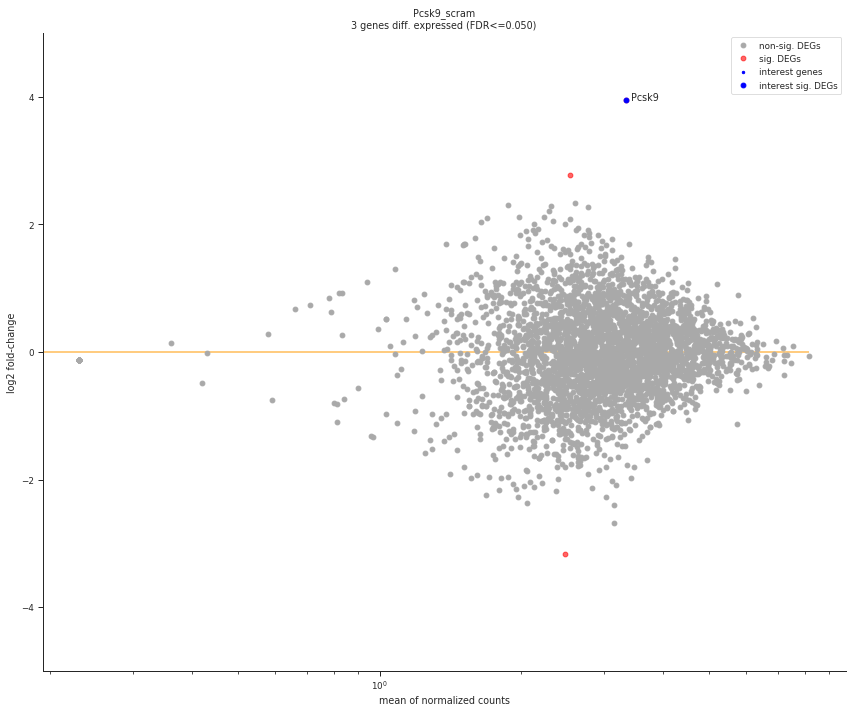

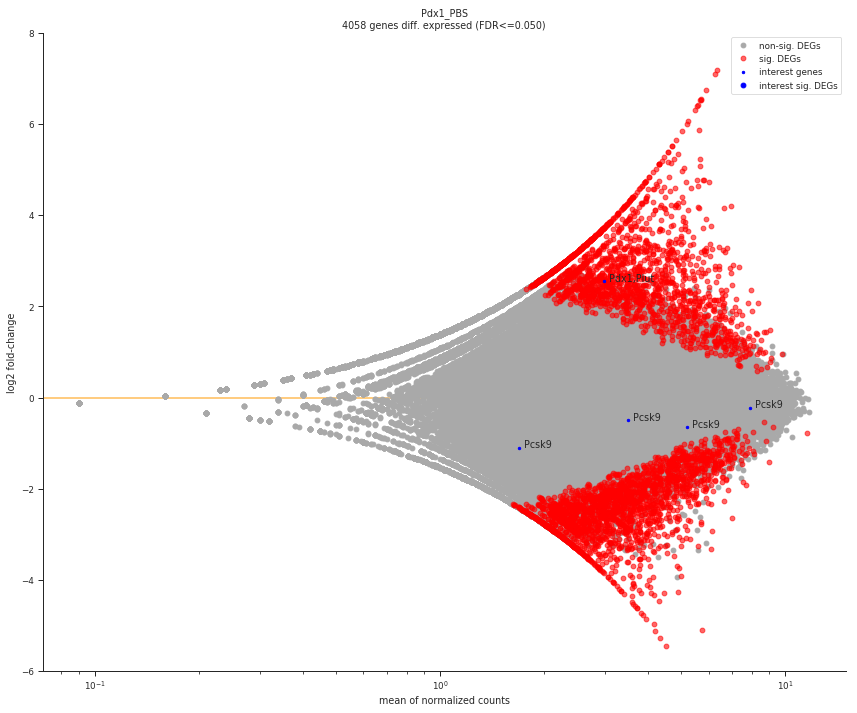

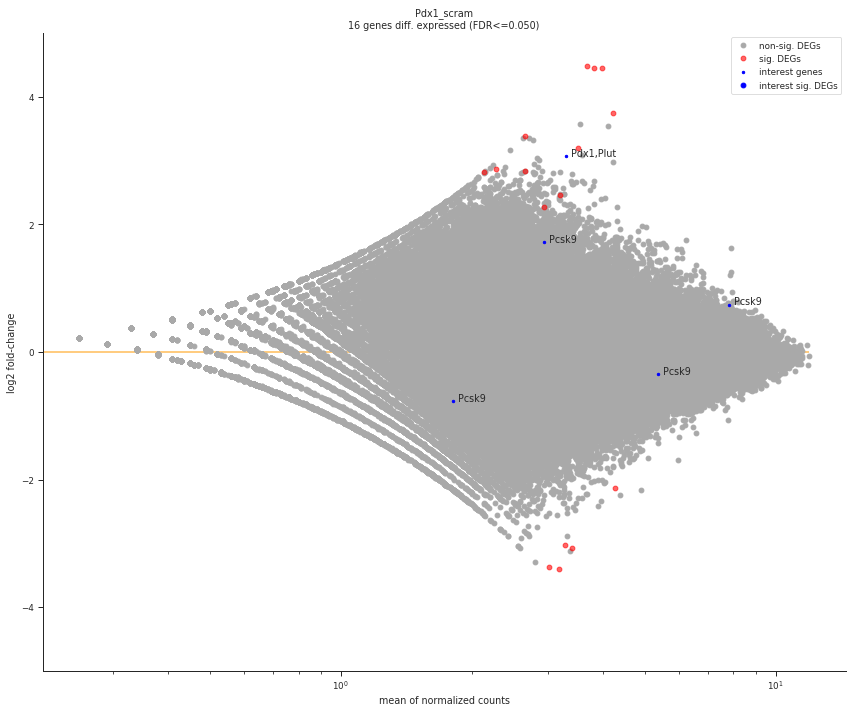

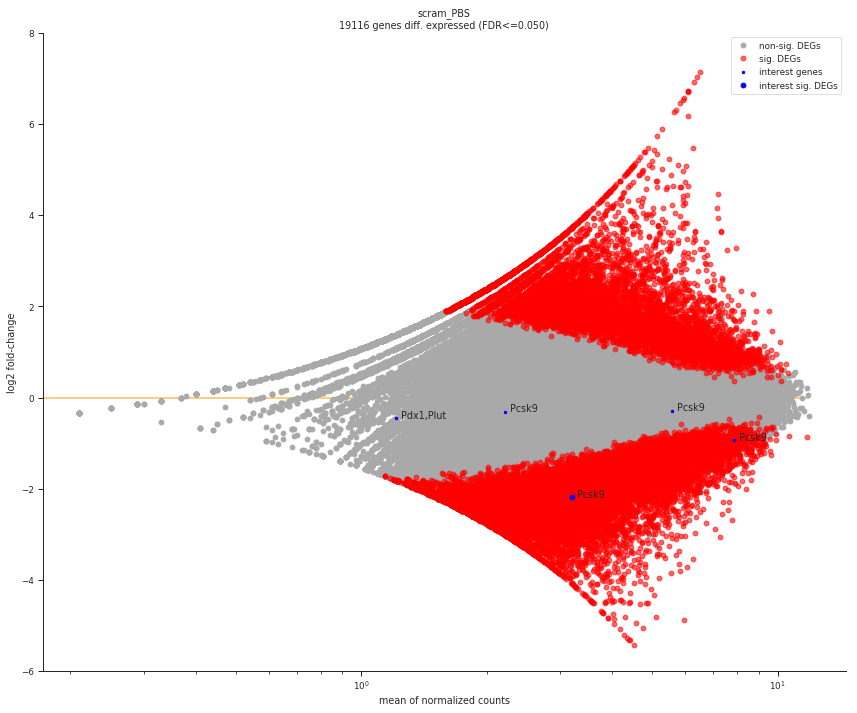

In [34]:
from IPython.display import display
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context("paper")
sns.set_style("whitegrid")
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

# Config
pval_thres = 0.05
top_to_report = 4000
special_genes = ['Pdx1,Plut', 'Pcsk9']
comparisons = [
    "Pcsk9_scram",
    "Pdx1_PBS",
    "Pdx1_scram", 
    "scram_PBS",
]
data_dir = '/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/diffbind'

for comparison in comparisons:
    df = pd.read_csv("%s/%s.diffBind.with_closest_gene.txt" % (data_dir, comparison),
                    sep="\t", index_col=0)
#     df.loc[:, "genes"] = df.index
    fig = plt.figure(figsize=(12, 10))
    ax = plt.subplot(1, 1, 1)
    df_non_sig = df[~(df.FDR<pval_thres) & (~df.genes.isin(special_genes))]
    ax.set_xscale('log')
    ax.plot(df_non_sig['Conc'].values, 
            df_non_sig['Fold'].values, 
            'o', color='darkgrey', label='non-sig. DEGs')

    ylims = [np.min([np.ceil(df['Fold'].min()-1), -5]), 
             np.max([np.floor(df['Fold'].max()+1), 5])]
    df_sig = df[df.FDR<=pval_thres]
    ax.plot(df_sig['Conc'].values, df_sig['Fold'].values, 'ro', alpha=0.6, label='sig. DEGs')

    # Annotate the top top_to_report
    df_annotate = df_sig.sort_values(by='FDR', ascending=True).head(top_to_report)

    # Annotate in particular IL1RN, HBG and EP300
    df_annotate_selected = df[df.genes.isin(special_genes)]
    ax.plot(df_annotate_selected['Conc'].values, 
            df_annotate_selected['Fold'].values,color='blue', 
            marker='.', linestyle = 'None', alpha=1, label='interest genes')
    for x, y, t in zip(df_annotate_selected['Conc'].values,
                       df_annotate_selected['Fold'].values, 
                       df_annotate_selected['genes'].values) :
        ax.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left',
                textcoords='offset points')
    df_annotate_selected = df_sig[df_sig.genes.isin(special_genes)]
    ax.plot(df_annotate_selected['Conc'].values, 
            df_annotate_selected['Fold'].values,color='blue', 
            marker='o', linestyle = 'None', alpha=1, label='interest sig. DEGs')

    plt.ylim(ylims)
    plt.xlabel("mean of normalized counts")
    plt.ylabel("log2 fold-change")
    plt.title("%s\n%d genes diff. expressed (FDR<=%.3f)" % (comparison, 
                                                             np.count_nonzero(df.FDR<=pval_thres),
                                                             pval_thres))
    plt.hlines(0, 0, df['Conc'].max(), color='#ffcc80', linewidth =2 )
    plt.legend()

    # Remove spines and tight the layout
    simpleaxis(ax)
    plt.tight_layout()

    # Save annotated MA plot
    plt.savefig("/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/diffbind/degs.%s%s.with_genes.annotated_plot_MA.pdf" % (comparison, shrinkage))

#     # Save annotated genes without pseudogenes
#     df_annotate.to_csv("/data/reddylab/Alex/collab/20180214_JoshBlack/results/rna_seq/degs%s.with_genes.sig_DE_no_pseudogenes.txt" % comparison,
#                       sep='\t',
#                       index=False)

    # print table of values 
    print "======", comparison, "======"
    display(df_annotate)

   


DESeq2

Add closest gene

In [41]:
%%bash
cd /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/differential_testing/deseq2/tmms

SAMPLES=($(/bin/ls -1 *.{PBS,scram,PBS.unshrunk,scram.unshrunk}.txt))
sbatch -pnew,all \
    --array=0-$((${#SAMPLES[@]}-1)) \
    --cpus-per-task 1 \
    --mem 4G \
    -o /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/logs/chipseq_deseq2.mmLiver.tmms.add_closest_gene.%a.out \
    <<'EOF'
#!/bin/bash

SAMPLES=($(/bin/ls -1 *.{PBS,scram,PBS.unshrunk,scram.unshrunk}.txt))
SAMPLE=${SAMPLES[${SLURM_ARRAY_TASK_ID}]}

tail -n+2 ${SAMPLE} \
| awk -F_ -vOFS="\t" '{print $1, $2, $3}' \
| cut -f1,2,3 \
| awk -vOFS="\t" '{print $1, $2, $3, $1"_"$2"_"$3}' \
| sort -k1,1 -k2,2n \
| bedtools closest \
    -wa \
    -nonamecheck \
    -D a \
    -a - \
    -b /data/reddylab/Reference_Data/Gencode/vM19/gencode.vM19.basic.annotation.bed \
| awk -vOFS="\t" \
    '{if(last==$4){genes=$11","genes;}else{if(genes){print peak, genes, distance}peak=$4; genes=$11; distance=$13; last=peak}}END{if(last==$4){genes=$11","genes;print peak, genes, distance}}' \
> ${SAMPLE/.txt/.closest_gene.txt}

EOF

Submitted batch job 10218175


Add closest gene info to DESeq2 results

In [42]:
import pandas as pd
samples = [
    "mmLiver_p300.K27ac.targeted_vs_mmLiver_p300.K27ac.PBS",
    "mmLiver_p300.K27ac.targeted_vs_mmLiver_p300.K27ac.scram",
    "mmLiver_p300.K27ac.scram_vs_mmLiver_p300.K27ac.PBS",
    "mmLiver_KRAB.K9me3.targeted_vs_mmLiver_KRAB.K9me3.PBS",
    "mmLiver_KRAB.K9me3.targeted_vs_mmLiver_KRAB.K9me3.scram",
    "mmLiver_KRAB.K9me3.scram_vs_mmLiver_KRAB.K9me3.PBS",
]
data_dir = '/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/differential_testing/deseq2/tmms/'
for sample in samples:
    for shrinkage in ['', '.unshrunk']:
        df = pd.read_csv("%s/%s%s.txt" % (data_dir, sample, shrinkage), sep='\t')
        df_closest= pd.read_csv("%s/%s.closest_gene.txt" % (data_dir, sample), index_col=0, sep='\t',
                                names=['peak', 'genes', 'distance'])
        df.join(df_closest, how='outer')\
            .sort_values(by=['padj'])\
            .to_csv("%s/%s%s.with_closest_gene.txt" % (data_dir, sample, shrinkage), sep='\t')

Add closest gene

In [13]:
%%bash
cd /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/differential_testing/deseq2/tmms/full_lib_size/

SAMPLES=($(/bin/ls -1 *.{PBS,scram,PBS.unshrunk,scram.unshrunk}.txt))
sbatch -pnew,all \
    --array=0-$((${#SAMPLES[@]}-1)) \
    --cpus-per-task 1 \
    --mem 4G \
    -o /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/logs/chipseq_deseq2.mmLiver.tmms.full_lib_size.add_closest_gene.%a.out \
    <<'EOF'
#!/bin/bash

SAMPLES=($(/bin/ls -1 *.{PBS,scram,PBS.unshrunk,scram.unshrunk}.txt))
SAMPLE=${SAMPLES[${SLURM_ARRAY_TASK_ID}]}

tail -n+2 ${SAMPLE} \
| awk -F_ -vOFS="\t" '{print $1, $2, $3}' \
| cut -f1,2,3 \
| awk -vOFS="\t" '{print $1, $2, $3, $1"_"$2"_"$3}' \
| sort -k1,1 -k2,2n \
| bedtools closest \
    -wa \
    -nonamecheck \
    -D a \
    -a - \
    -b /data/reddylab/Reference_Data/Gencode/vM19/gencode.vM19.basic.annotation.bed \
| awk -vOFS="\t" \
    '{if(last==$4){genes=$11","genes;}else{if(genes){print peak, genes, distance}peak=$4; genes=$11; distance=$13; last=peak}}END{if(last==$4){genes=$11","genes;print peak, genes, distance}}' \
> ${SAMPLE/.txt/.closest_gene.txt}

EOF

Submitted batch job 10220632


Add closest gene info to DESeq2 results

In [16]:
import pandas as pd
samples = [
#     "mmLiver_p300.K27ac.targeted_vs_mmLiver_p300.K27ac.PBS",
#     "mmLiver_p300.K27ac.targeted_vs_mmLiver_p300.K27ac.scram",
#     "mmLiver_p300.K27ac.scram_vs_mmLiver_p300.K27ac.PBS",
    "mmLiver_KRAB.K9me3.targeted_vs_mmLiver_KRAB.K9me3.PBS",
    "mmLiver_KRAB.K9me3.targeted_vs_mmLiver_KRAB.K9me3.scram",
    "mmLiver_KRAB.K9me3.scram_vs_mmLiver_KRAB.K9me3.PBS",
]
data_dir = '/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/differential_testing/deseq2/tmms/full_lib_size'
for sample in samples:
    for shrinkage in ['', '.unshrunk']:
        df = pd.read_csv("%s/%s%s.txt" % (data_dir, sample, shrinkage), sep='\t')
        df_closest= pd.read_csv("%s/%s.closest_gene.txt" % (data_dir, sample), index_col=0, sep='\t',
                                names=['peak', 'genes', 'distance'])
        df.join(df_closest, how='outer')\
            .sort_values(by=['padj'])\
            .to_csv("%s/%s%s.with_closest_gene.txt" % (data_dir, sample, shrinkage), sep='\t')

Create annotated MA plots with DESeq2 using the EFFECTIVE_LIB_SIZE

In [38]:
%matplotlib inline

====== mmLiver_p300.K27ac.targeted_vs_mmLiver_p300.K27ac.PBS ======


,baseMean,log2FoldChange,lfcSE,pvalue,padj,genes,distance
chr6_28704715_28707849,94.726001,3.271949,0.321957,7.906091e-26,8.109040e-21,"Lrrc4,Snd1",0
chr9_115235344_115237874,75.583614,4.373629,0.478705,4.805350e-24,2.464352e-19,Osbpl10,-3120
chr2_155809155_155811200,77.450604,4.034571,0.430411,8.578864e-24,2.598570e-19,Mmp24,0
chr14_54120367_54123079,77.476344,4.572170,0.517535,1.013414e-23,2.598570e-19,"Trdd2,Gm30275",0
chr4_115855705_115858986,87.631565,4.505075,0.508925,1.697828e-23,3.482823e-19,Mknk1,0
chr15_62565438_62568505,81.597564,4.522061,0.518779,4.710020e-23,8.051544e-19,Gm41333,0
chr11_74521486_74525129,184.736979,3.163795,0.340861,5.376969e-22,7.878565e-18,Rap1gap2,0
chr9_45688769_45691600,91.576556,4.903976,0.620949,1.507426e-21,1.932651e-17,Dscaml1,0
chr2_93878785_93883159,126.251817,7.737269,0.895439,3.072008e-20,3.500963e-16,Accsl,-9629
chr19_53411991_53415155,78.143173,3.863991,0.455664,6.456549e-20,6.622289e-16,Smndc1,-21419


====== mmLiver_p300.K27ac.targeted_vs_mmLiver_p300.K27ac.PBS ======


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,distance
chr6_28704715_28707849,94.726001,3.445068,0.327841,10.508355,7.906091e-26,1.030717e-20,"Lrrc4,Snd1",0
chr9_115235344_115237874,75.583614,4.771808,0.471818,10.113663,4.805350e-24,3.132368e-19,Osbpl10,-3120
chr14_54120367_54123079,77.476344,5.003067,0.498297,10.040323,1.013414e-23,3.302969e-19,"Trdd2,Gm30275",0
chr2_155809155_155811200,77.450604,4.375271,0.435058,10.056744,8.578864e-24,3.302969e-19,Mmp24,0
chr4_115855705_115858986,87.631565,4.933160,0.493845,9.989296,1.697828e-23,4.426918e-19,Mknk1,0
chr15_62565438_62568505,81.597564,4.962188,0.501858,9.887640,4.710020e-23,1.023409e-18,Gm41333,0
chr11_74521486_74525129,184.736979,3.354221,0.347920,9.640795,5.376969e-22,1.001422e-17,Rap1gap2,0
chr9_45688769_45691600,91.576556,5.407456,0.567152,9.534408,1.507426e-21,2.456538e-17,Dscaml1,0
chr2_93878785_93883159,126.251817,8.140224,0.883231,9.216415,3.072008e-20,4.449975e-16,Accsl,-9629
chr19_53411991_53415155,78.143173,4.245824,0.464715,9.136401,6.456549e-20,8.417403e-16,Smndc1,-21419


====== mmLiver_p300.K27ac.targeted_vs_mmLiver_p300.K27ac.scram ======


,baseMean,log2FoldChange,lfcSE,pvalue,padj,genes,distance
chr16_43045927_43046875,28.185143,2.435611,0.978584,1.963092e-07,0.025593,Zbtb20,0


====== mmLiver_p300.K27ac.targeted_vs_mmLiver_p300.K27ac.scram ======


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,distance
chr16_43045927_43046875,28.185143,3.259693,0.626527,5.202799,1.963092e-07,0.025593,Zbtb20,0


====== mmLiver_KRAB.K9me3.targeted_vs_mmLiver_KRAB.K9me3.PBS ======


,baseMean,log2FoldChange,lfcSE,pvalue,padj,genes,distance
chr4_106463479_106465480,8.303896,1.63402,1.86314,0.000006,0.021087,Pcsk9,0


====== mmLiver_KRAB.K9me3.targeted_vs_mmLiver_KRAB.K9me3.PBS ======


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,distance
chr4_106463479_106465480,8.303896,3.935151,0.868768,4.529578,0.000006,0.021087,Pcsk9,0


====== mmLiver_KRAB.K9me3.targeted_vs_mmLiver_KRAB.K9me3.scram ======


,baseMean,log2FoldChange,lfcSE,pvalue,padj,genes,distance
chr4_106463479_106465480,8.303896,3.455041,1.475375,0.000002,0.007589,Pcsk9,0


====== mmLiver_KRAB.K9me3.targeted_vs_mmLiver_KRAB.K9me3.scram ======


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,distance
chr4_106463479_106465480,8.303896,4.603464,0.970995,4.740975,0.000002,0.007589,Pcsk9,0


====== mmLiver_KRAB.K9me3.scram_vs_mmLiver_KRAB.K9me3.PBS ======


,baseMean,log2FoldChange,lfcSE,pvalue,padj,genes,distance


====== mmLiver_KRAB.K9me3.scram_vs_mmLiver_KRAB.K9me3.PBS ======


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,distance


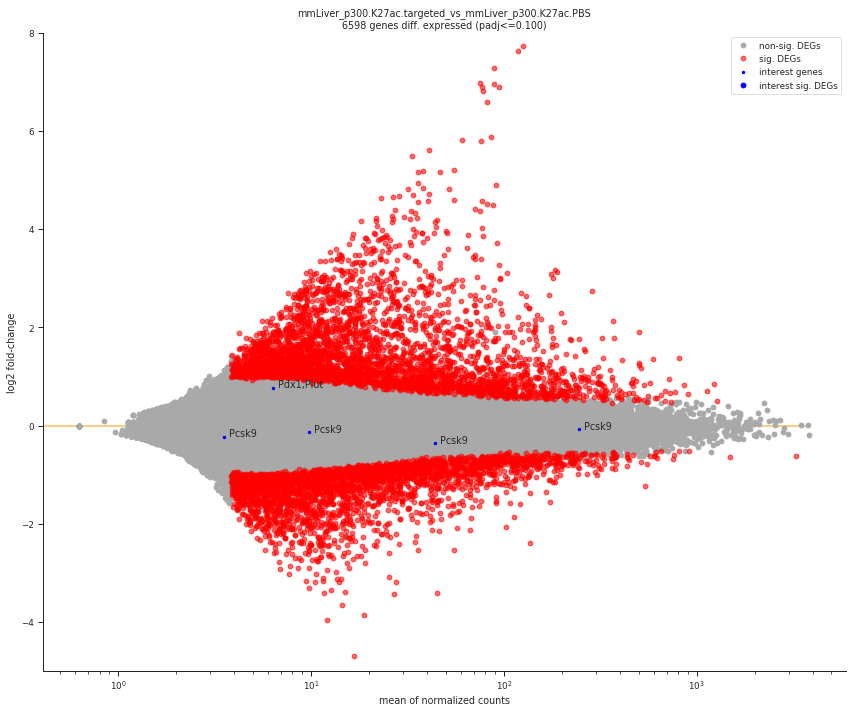

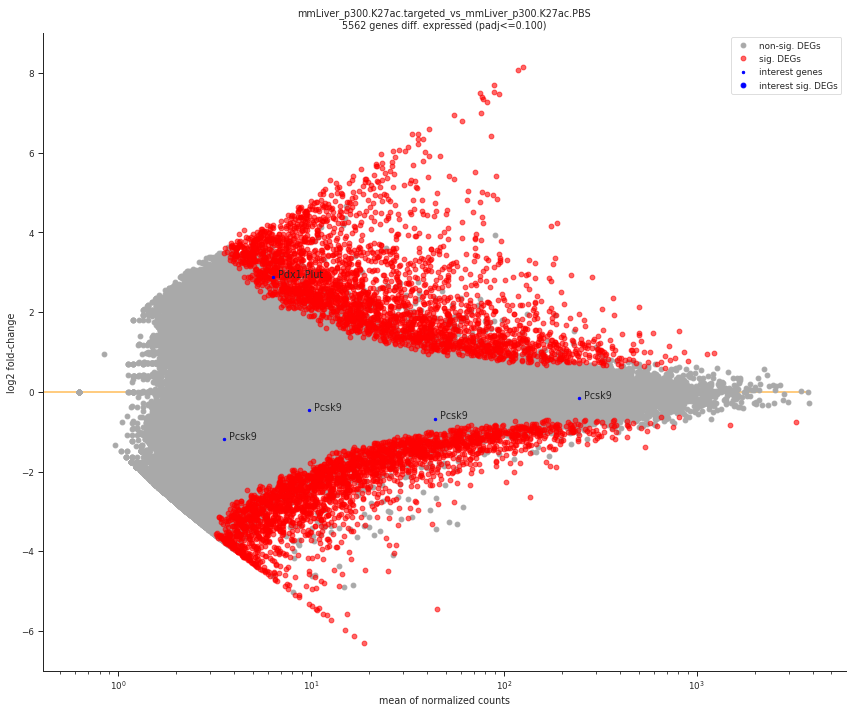

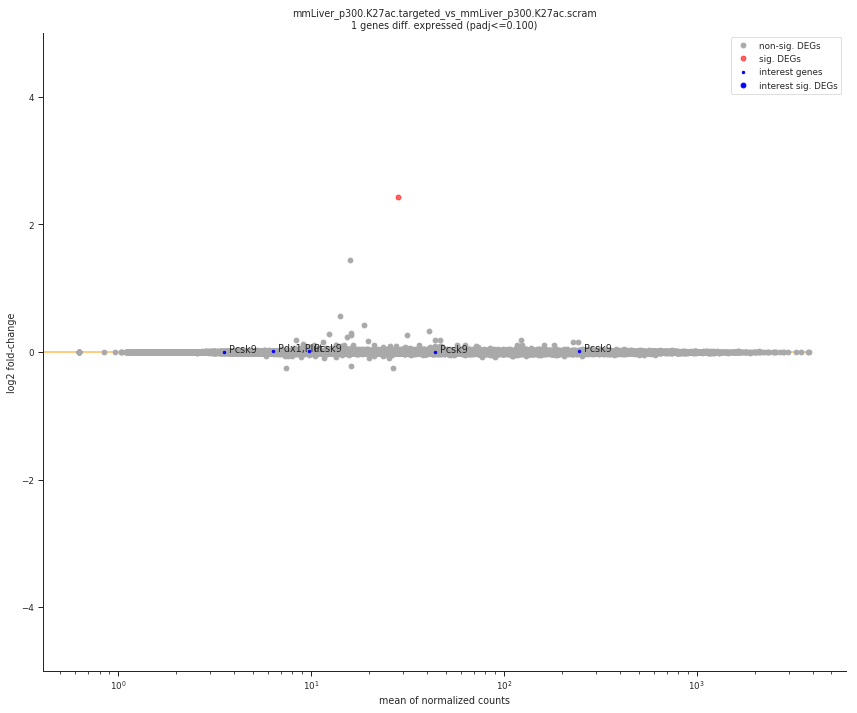

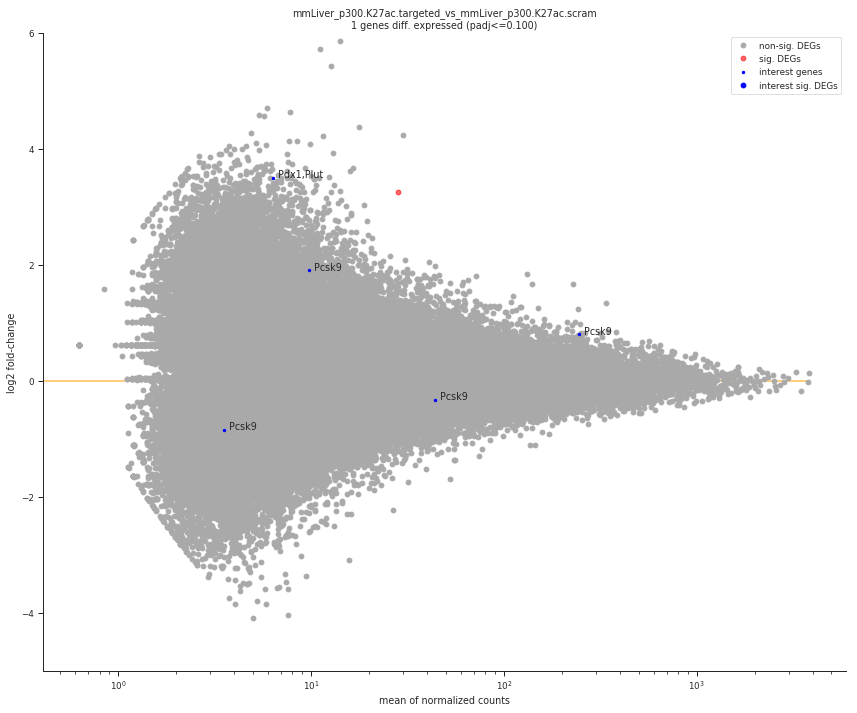

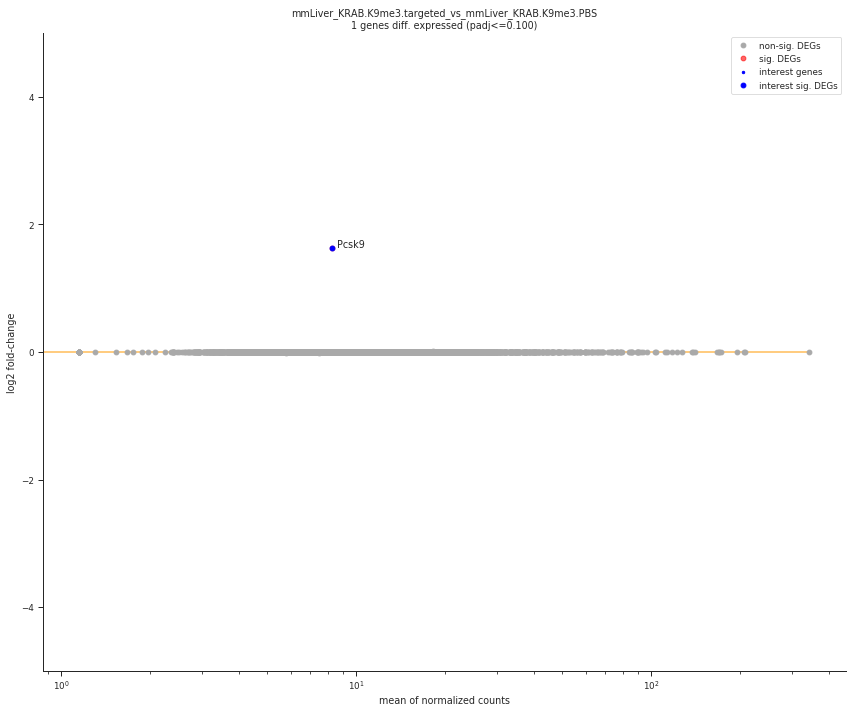

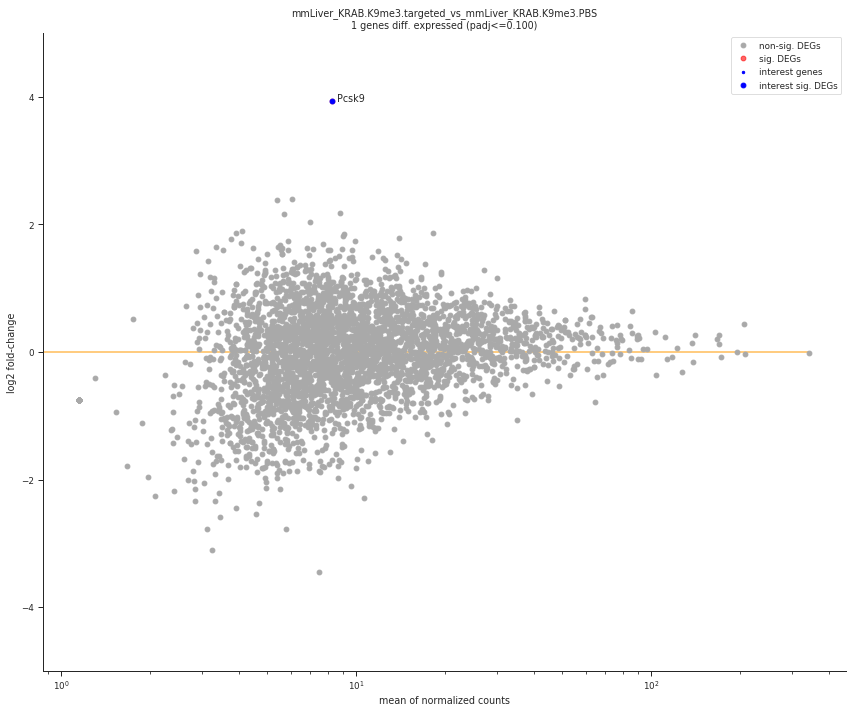

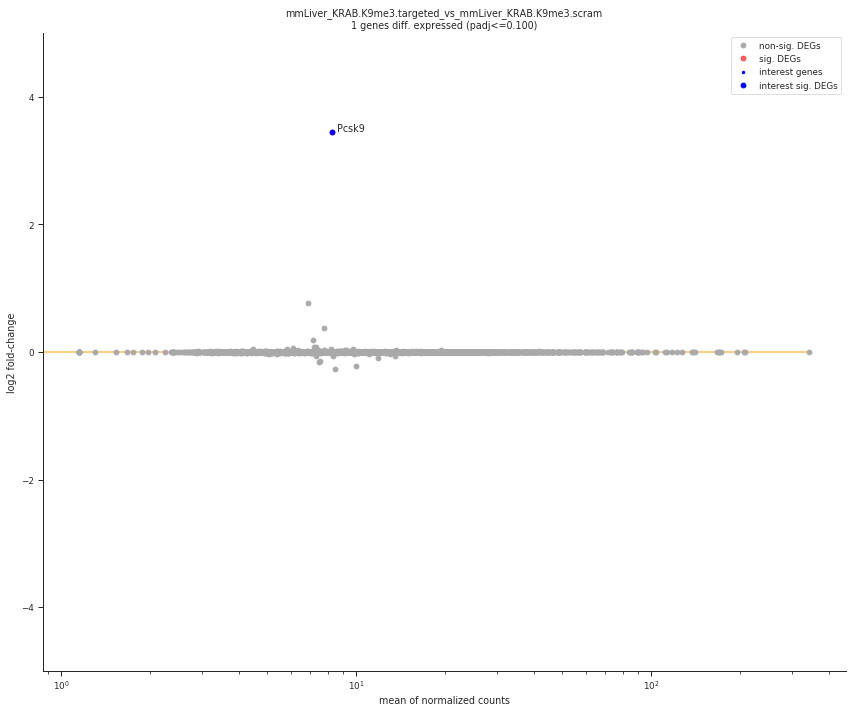

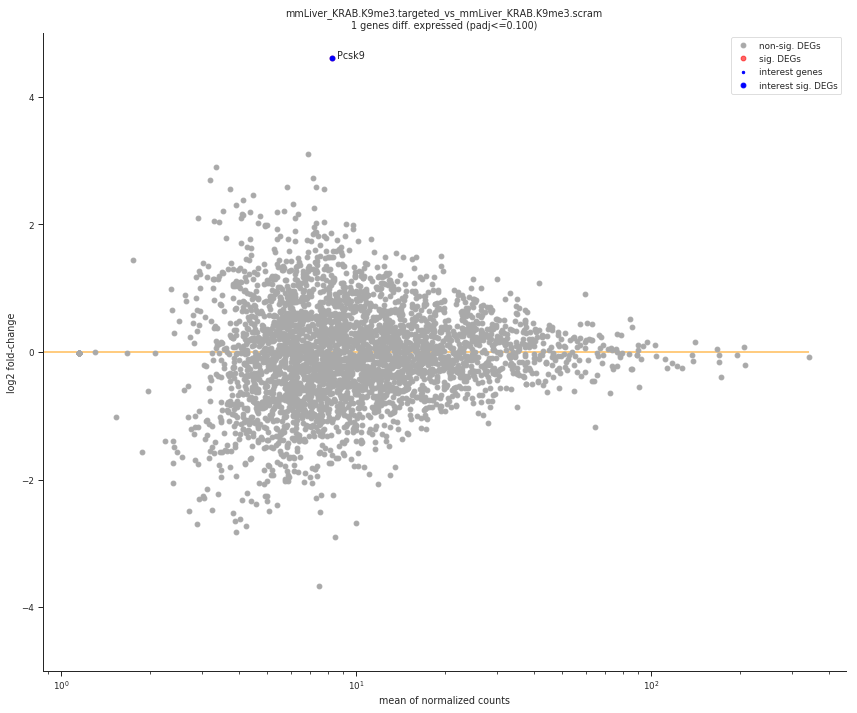

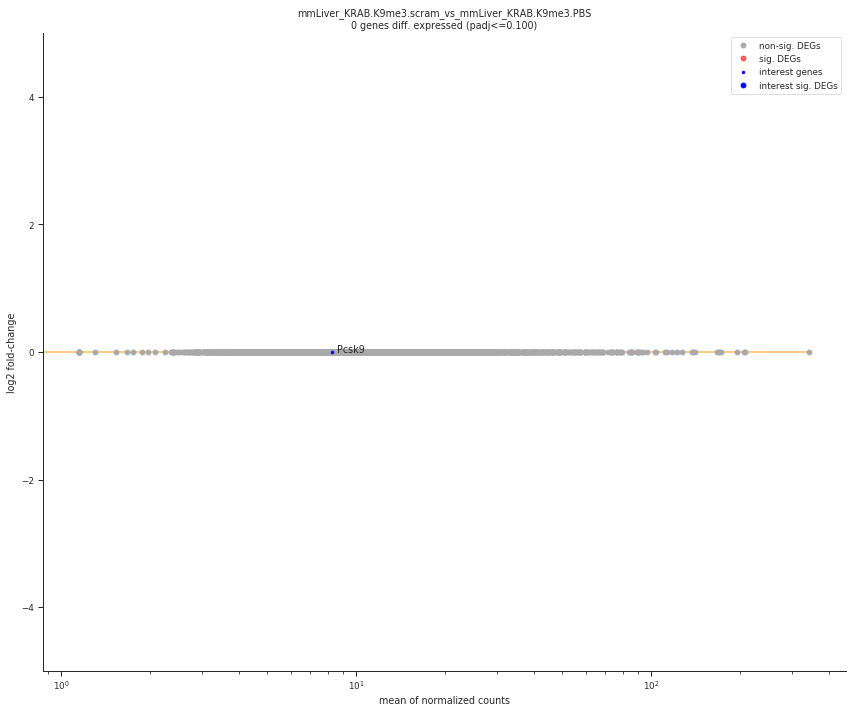

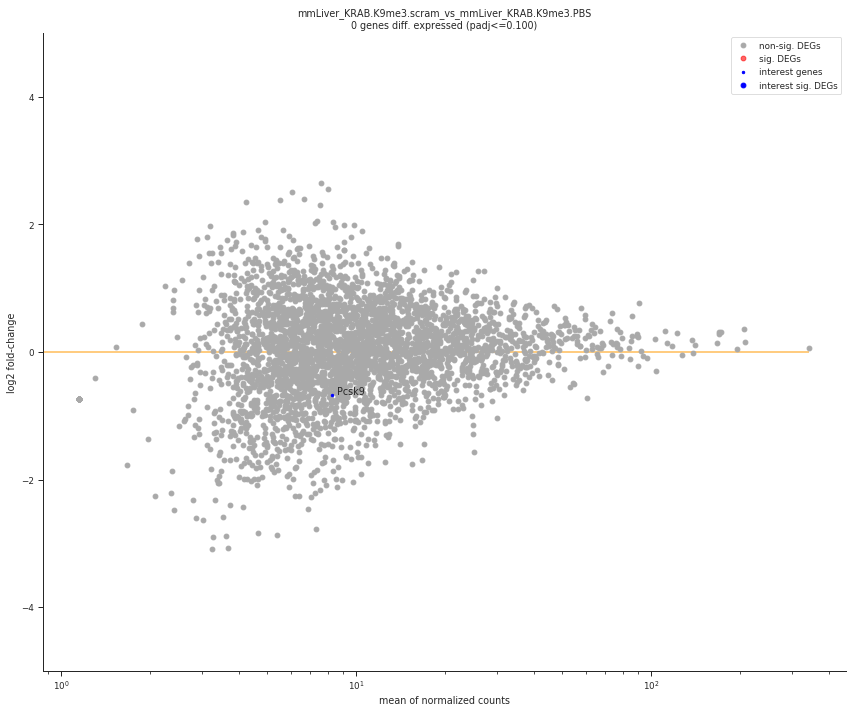

In [43]:
from IPython.display import display
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context("paper")
sns.set_style("whitegrid")
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

# Config
pval_thres = 0.1
top_to_report = 4000
special_genes = ['Pdx1,Plut', 'Pcsk9']
comparisons = [
    "mmLiver_p300.K27ac.targeted_vs_mmLiver_p300.K27ac.PBS",
    "mmLiver_p300.K27ac.targeted_vs_mmLiver_p300.K27ac.scram",
#     "mmLiver_p300.K27ac.scram_vs_mmLiver_p300.K27ac.PBS",
    "mmLiver_KRAB.K9me3.targeted_vs_mmLiver_KRAB.K9me3.PBS",
    "mmLiver_KRAB.K9me3.targeted_vs_mmLiver_KRAB.K9me3.scram",
    "mmLiver_KRAB.K9me3.scram_vs_mmLiver_KRAB.K9me3.PBS",
]

data_dir = '/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/differential_testing/deseq2/tmms'

for comparison in comparisons:
    for shrinkage in ['', '.unshrunk']:
        df = pd.read_csv("%s/%s%s.with_closest_gene.txt" % (data_dir, comparison, shrinkage),
                        sep="\t", index_col=0)
    #     df.loc[:, "genes"] = df.index
        fig = plt.figure(figsize=(12, 10))
        ax = plt.subplot(1, 1, 1)
        df_non_sig = df[~(df.padj<pval_thres) & (~df.genes.isin(special_genes))]
        ax.set_xscale('log')
        ax.plot(df_non_sig['baseMean'].values, 
                df_non_sig['log2FoldChange'].values, 
                'o', color='darkgrey', label='non-sig. DEGs')

        ylims = [np.min([np.ceil(df['log2FoldChange'].min()-1), -5]), 
                 np.max([np.floor(df['log2FoldChange'].max()+1), 5])]
        df_sig = df[df.padj<=pval_thres]
        ax.plot(df_sig['baseMean'].values, df_sig['log2FoldChange'].values, 'ro', alpha=0.6, label='sig. DEGs')

        # Annotate the top top_to_report
        df_annotate = df_sig.sort_values(by='padj', ascending=True).head(top_to_report)

        # Annotate in particular IL1RN, HBG and EP300
        df_annotate_selected = df[df.genes.isin(special_genes)]
        ax.plot(df_annotate_selected['baseMean'].values, 
                df_annotate_selected['log2FoldChange'].values,color='blue', 
                marker='.', linestyle = 'None', alpha=1, label='interest genes')
        for x, y, t in zip(df_annotate_selected['baseMean'].values,
                           df_annotate_selected['log2FoldChange'].values, 
                           df_annotate_selected['genes'].values) :
            ax.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left',
                    textcoords='offset points')
        df_annotate_selected = df_sig[df_sig.genes.isin(special_genes)]
        ax.plot(df_annotate_selected['baseMean'].values, 
                df_annotate_selected['log2FoldChange'].values,color='blue', 
                marker='o', linestyle = 'None', alpha=1, label='interest sig. DEGs')

        plt.ylim(ylims)
        plt.xlabel("mean of normalized counts")
        plt.ylabel("log2 fold-change")
        plt.title("%s\n%d genes diff. expressed (padj<=%.3f)" % (comparison, 
                                                                 np.count_nonzero(df.padj<=pval_thres),
                                                                 pval_thres))
        plt.hlines(0, 0, df['baseMean'].max(), color='#ffcc80', linewidth =2 )
        plt.legend()

        # Remove spines and tight the layout
        simpleaxis(ax)
        plt.tight_layout()

        # Save annotated MA plot
        plt.savefig("%s/degs.%s%s.with_genes.annotated_plot_MA.pdf" % (data_dir, comparison, shrinkage))

    #     # Save annotated genes without pseudogenes
    #     df_annotate.to_csv("/data/reddylab/Alex/collab/20180214_JoshBlack/results/rna_seq/degs%s.with_genes.sig_DE_no_pseudogenes.txt" % comparison,
    #                       sep='\t',
    #                       index=False)

        # print table of values 
        print "======", comparison, "======"
        display(df_annotate)
    
   


====== mmLiver_KRAB.K9me3.targeted_vs_mmLiver_KRAB.K9me3.PBS ======


,baseMean,log2FoldChange,lfcSE,pvalue,padj,genes,distance
chr4_106463479_106465480,7.326832,0.420349,1.160768,0.00001,0.035159,Pcsk9,0


====== mmLiver_KRAB.K9me3.targeted_vs_mmLiver_KRAB.K9me3.PBS ======


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,distance
chr4_106463479_106465480,7.326832,3.817539,0.863628,4.420351,0.00001,0.035159,Pcsk9,0


====== mmLiver_KRAB.K9me3.targeted_vs_mmLiver_KRAB.K9me3.scram ======


,baseMean,log2FoldChange,lfcSE,pvalue,padj,genes,distance
chr4_106463479_106465480,7.326832,2.98608,1.942405,0.000004,0.015075,Pcsk9,0


====== mmLiver_KRAB.K9me3.targeted_vs_mmLiver_KRAB.K9me3.scram ======


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,distance
chr4_106463479_106465480,7.326832,4.820954,1.048036,4.59999,0.000004,0.015075,Pcsk9,0


====== mmLiver_KRAB.K9me3.scram_vs_mmLiver_KRAB.K9me3.PBS ======


,baseMean,log2FoldChange,lfcSE,pvalue,padj,genes,distance


====== mmLiver_KRAB.K9me3.scram_vs_mmLiver_KRAB.K9me3.PBS ======


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,distance


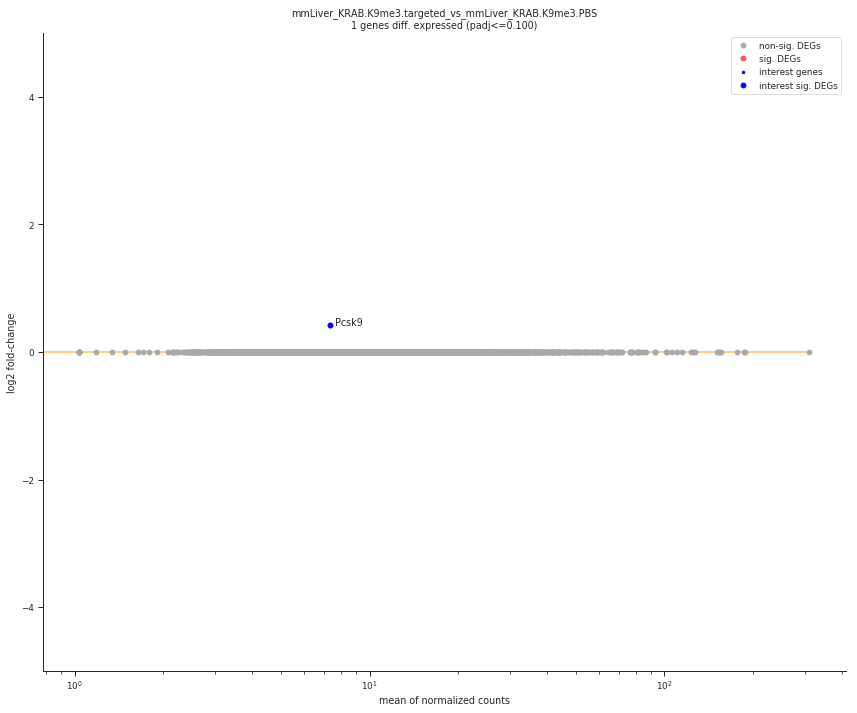

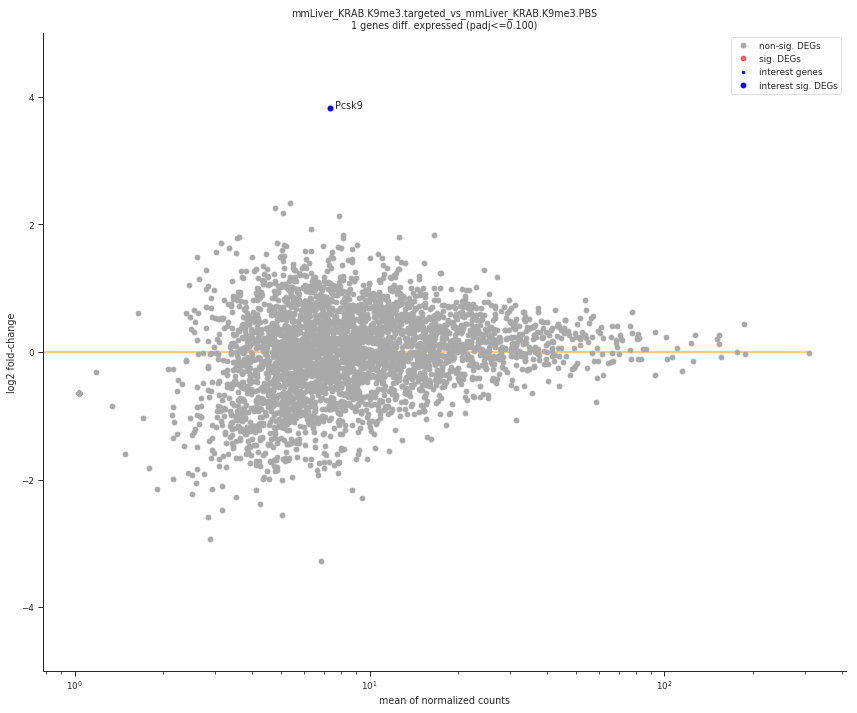

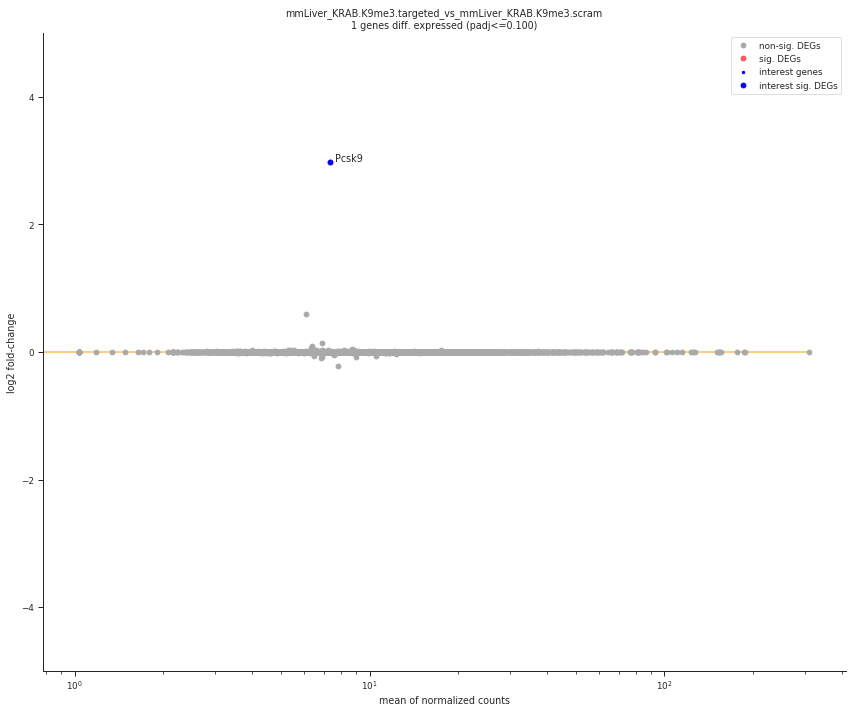

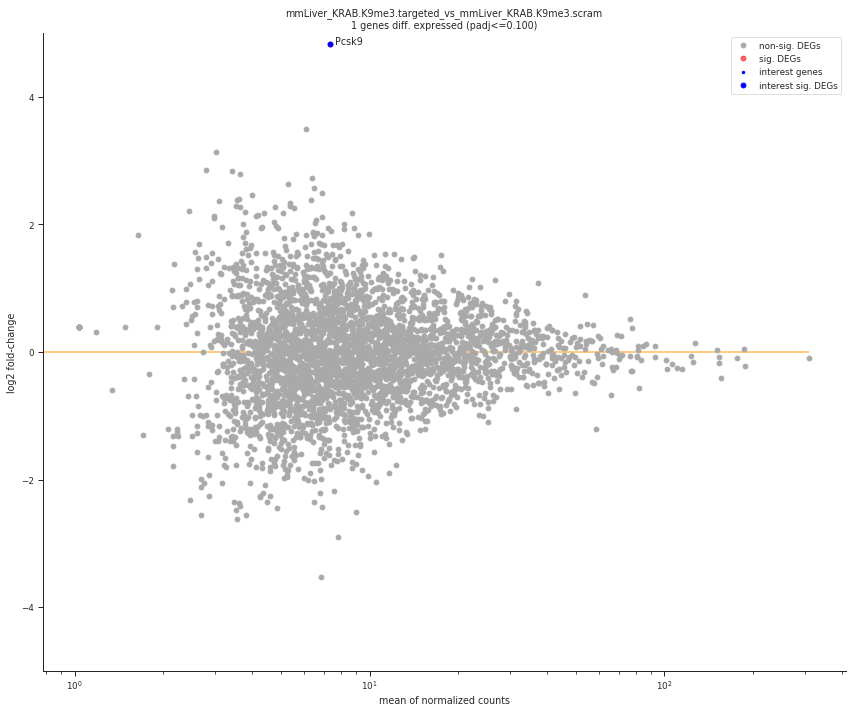

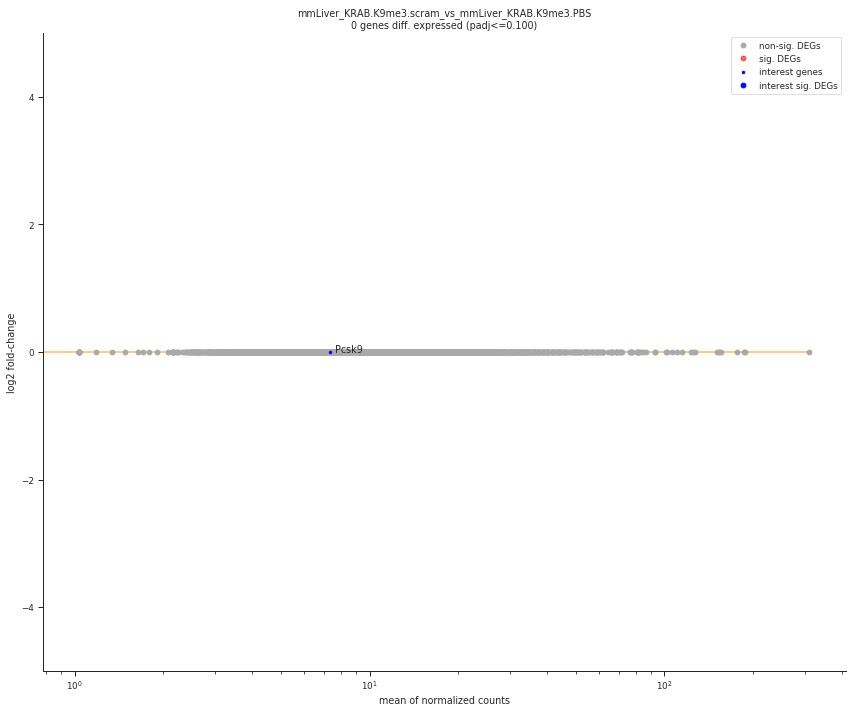

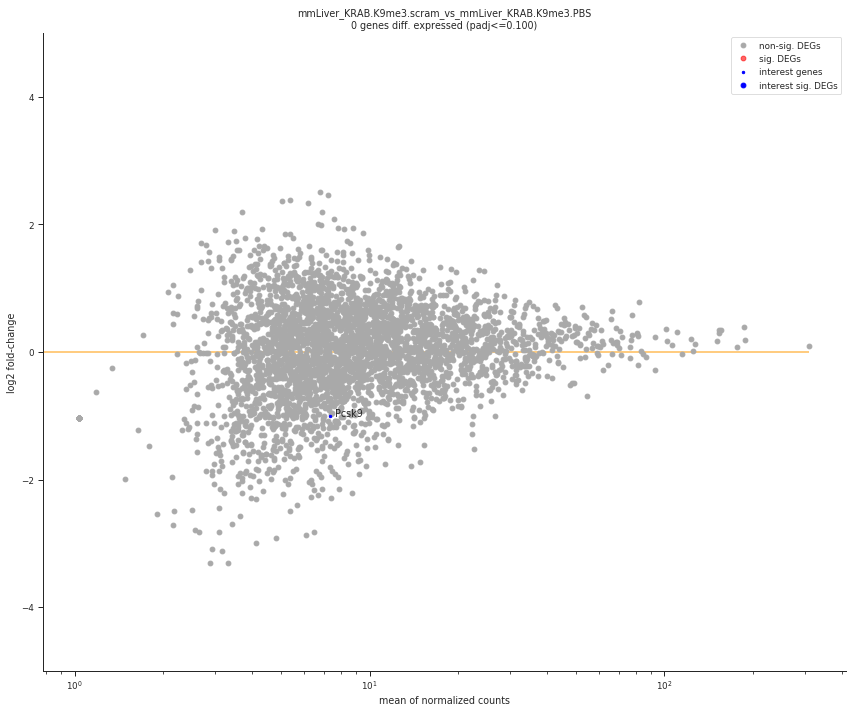

In [17]:
from IPython.display import display
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context("paper")
sns.set_style("whitegrid")
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

# Config
pval_thres = 0.1
top_to_report = 4000
special_genes = ['Pdx1,Plut', 'Pcsk9']
comparisons = [
#     "mmLiver_p300.K27ac.targeted_vs_mmLiver_p300.K27ac.PBS",
#     "mmLiver_p300.K27ac.targeted_vs_mmLiver_p300.K27ac.scram",
#     "mmLiver_p300.K27ac.scram_vs_mmLiver_p300.K27ac.PBS",
    "mmLiver_KRAB.K9me3.targeted_vs_mmLiver_KRAB.K9me3.PBS",
    "mmLiver_KRAB.K9me3.targeted_vs_mmLiver_KRAB.K9me3.scram",
    "mmLiver_KRAB.K9me3.scram_vs_mmLiver_KRAB.K9me3.PBS",
]

data_dir = '/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/differential_testing/deseq2/tmms/full_lib_size'

for comparison in comparisons:
    for shrinkage in ['', '.unshrunk']:
        df = pd.read_csv("%s/%s%s.with_closest_gene.txt" % (data_dir, comparison, shrinkage),
                        sep="\t", index_col=0)
    #     df.loc[:, "genes"] = df.index
        fig = plt.figure(figsize=(12, 10))
        ax = plt.subplot(1, 1, 1)
        df_non_sig = df[~(df.padj<pval_thres) & (~df.genes.isin(special_genes))]
        ax.set_xscale('log')
        ax.plot(df_non_sig['baseMean'].values, 
                df_non_sig['log2FoldChange'].values, 
                'o', color='darkgrey', label='non-sig. DEGs')

        ylims = [np.min([np.ceil(df['log2FoldChange'].min()-1), -5]), 
                 np.max([np.floor(df['log2FoldChange'].max()+1), 5])]
        df_sig = df[df.padj<=pval_thres]
        ax.plot(df_sig['baseMean'].values, df_sig['log2FoldChange'].values, 'ro', alpha=0.6, label='sig. DEGs')

        # Annotate the top top_to_report
        df_annotate = df_sig.sort_values(by='padj', ascending=True).head(top_to_report)

        # Annotate in particular IL1RN, HBG and EP300
        df_annotate_selected = df[df.genes.isin(special_genes)]
        ax.plot(df_annotate_selected['baseMean'].values, 
                df_annotate_selected['log2FoldChange'].values,color='blue', 
                marker='.', linestyle = 'None', alpha=1, label='interest genes')
        for x, y, t in zip(df_annotate_selected['baseMean'].values,
                           df_annotate_selected['log2FoldChange'].values, 
                           df_annotate_selected['genes'].values) :
            ax.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left',
                    textcoords='offset points')
        df_annotate_selected = df_sig[df_sig.genes.isin(special_genes)]
        ax.plot(df_annotate_selected['baseMean'].values, 
                df_annotate_selected['log2FoldChange'].values,color='blue', 
                marker='o', linestyle = 'None', alpha=1, label='interest sig. DEGs')

        plt.ylim(ylims)
        plt.xlabel("mean of normalized counts")
        plt.ylabel("log2 fold-change")
        plt.title("%s\n%d genes diff. expressed (padj<=%.3f)" % (comparison, 
                                                                 np.count_nonzero(df.padj<=pval_thres),
                                                                 pval_thres))
        plt.hlines(0, 0, df['baseMean'].max(), color='#ffcc80', linewidth =2 )
        plt.legend()

        # Remove spines and tight the layout
        simpleaxis(ax)
        plt.tight_layout()

        # Save annotated MA plot
        plt.savefig("%s/degs.%s%s.with_genes.annotated_plot_MA.pdf" % (data_dir, comparison, shrinkage))

    #     # Save annotated genes without pseudogenes
    #     df_annotate.to_csv("/data/reddylab/Alex/collab/20180214_JoshBlack/results/rna_seq/degs%s.with_genes.sig_DE_no_pseudogenes.txt" % comparison,
    #                       sep='\t',
    #                       index=False)

        # print table of values 
        print "======", comparison, "======"
        display(df_annotate)
    
   


In [4]:
%%writefile /data/reddylab/Alex/collab/20190701_Matt/data/chip_seq/metadata/scram_sequence.fa
>scram_sequence
GCACTACCAGAGCTAACTCA


Overwriting /data/reddylab/Alex/collab/20190701_Matt/data/chip_seq/metadata/scram_sequence.fa


In [14]:
%%writefile /data/reddylab/Alex/collab/20190701_Matt/data/chip_seq/metadata/scram_sequence.revcomp.fa
>scram_sequence_revcomp
TGAGTTAGGTGTGGTAGTGG


Writing /data/reddylab/Alex/collab/20190701_Matt/data/chip_seq/metadata/scram_sequence.revcomp.fa


In [3]:
%%writefile /data/reddylab/Alex/collab/20190701_Matt/data/chip_seq/metadata/scram_offtarget_peak.fa
>mm10_dna range=chr14:76877400-76877806 5'pad=0 3'pad=0 strand=+ repeatMasking=none
TGAGTTTGGCTGAAAACACTACAGGGCAAAGGACATGCTGTTTGTGTTAA
GAATAACTCGGAGCTCTTGGTTTGGTCCACTGCCATATGCCCTTTGATTT
TACAGAGACATTGAAATTTGATGAAGGTACATCGTCAAATTCCAGAATCA
TTACTCATGGATAGTAAAAAAAAAAAAGTGGTGATATAGCTGCTACACTT
CAATGGGGCCCCGGAAATTCCATCCCTGCTTCCTGACTCCTTCACTTAGC
ATCCTCTTGGCCATAGCTCAAGTGCACATTCGGTCAGAAATAACCTAGGC
TTAAAGAGGGGGTGTGAACTCCATGTTTAACATTGCTGATTATAATAATC
AATGGGATATTTTGACTACCTTGATATGGGATGCTTTTCTAAACAACATG
AAAATTT

Writing /data/reddylab/Alex/collab/20190701_Matt/data/chip_seq/metadata/scram_offtarget_peak.fa


In [12]:
def revcomp(s):
    comp = {'A':'T', 'C': 'G', 'T': 'A', 'G':'G'}
    return ''.join([comp[c] for c in s[::-1]])

In [13]:
revcomp('GCACTACCAGAGCTAACTCA')

'TGAGTTAGGTGTGGTAGTGG'

In [5]:
%%bash
mkdir -p /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/offtargets
/data/reddylab/Alex/bin/EMBOSS-6.6.0/bin/bin/needle \
    -asequence /data/reddylab/Alex/collab/20190701_Matt/data/chip_seq/metadata/scram_sequence.fa \
    -bsequence /data/reddylab/Alex/collab/20190701_Matt/data/chip_seq/metadata/scram_offtarget_peak.fa \
    -gapopen 25 \
    -gapextend 0.5 \
    -outfile /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/offtargets/scram.needle.out
    

Needleman-Wunsch global alignment of two sequences


In [6]:
!cat /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/offtargets/scram.needle.out

########################################
# Program: needle
# Rundate: Mon  2 Mar 2020 11:18:33
# Commandline: needle
#    -asequence /data/reddylab/Alex/collab/20190701_Matt/data/chip_seq/metadata/scram_sequence.fa
#    -bsequence /data/reddylab/Alex/collab/20190701_Matt/data/chip_seq/metadata/scram_offtarget_peak.fa
#    -gapopen 25
#    -gapextend 0.5
#    -outfile /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/offtargets/scram.needle.out
# Align_format: srspair
# Report_file: /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/offtargets/scram.needle.out
########################################

#=======================================
#
# Aligned_sequences: 2
# 1: scram_sequence
# 2: mm10_dna
# Matrix: EDNAFULL
# Gap_penalty: 25.0
# Extend_penalty: 0.5
#
# Length: 407
# Identity:      13/407 ( 3.2%)
# Similarity:    13/407 ( 3.2%)
# Gaps:         387/407 (95.1%)
# Score: 11.5
# 
#
#=======================================

scram_sequenc      0 ----------------------

In [18]:
%%bash
/data/reddylab/Alex/bin/EMBOSS-6.6.0/bin/bin/water \
    -asequence /data/reddylab/Alex/collab/20190701_Matt/data/chip_seq/metadata/scram_sequence.fa \
    -bsequence /data/reddylab/Alex/collab/20190701_Matt/data/chip_seq/metadata/scram_offtarget_peak.fa \
    -gapopen 25 \
    -gapextend 0.5 \
    -outfile /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/offtargets/scram.water.out
    

Smith-Waterman local alignment of sequences


In [19]:
!cat /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/offtargets/scram.water.out

########################################
# Program: water
# Rundate: Mon  2 Mar 2020 11:25:27
# Commandline: water
#    -asequence /data/reddylab/Alex/collab/20190701_Matt/data/chip_seq/metadata/scram_sequence.fa
#    -bsequence /data/reddylab/Alex/collab/20190701_Matt/data/chip_seq/metadata/scram_offtarget_peak.fa
#    -gapopen 25
#    -gapextend 0.5
#    -outfile /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/offtargets/scram.water.out
# Align_format: srspair
# Report_file: /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/offtargets/scram.water.out
########################################

#=======================================
#
# Aligned_sequences: 2
# 1: scram_sequence
# 2: mm10_dna
# Matrix: EDNAFULL
# Gap_penalty: 25.0
# Extend_penalty: 0.5
#
# Length: 10
# Identity:       8/10 (80.0%)
# Similarity:     8/10 (80.0%)
# Gaps:           0/10 ( 0.0%)
# Score: 32.0
# 
#
#=======================================

scram_sequenc      2 CACTACCAGA     11
            